On reste sur 2020-2022 pour entrainer notre modèle sur l'europe puis on essaye de généraliser sur d'autres pays hors europe (asie, afrique, USA...)

Allemagne pas de hospitalisation

retirer Bosnie, north macedonia, albanie, république tchèques, kosovo, maltes 

1096, de nan on prend pas la features

retire les données avant 01/02/2020 jusqu'à fin 2022
2021 mettre des 0 pour les NaN d'hospitalisation, vaccins, tests ...

Questions :
- Prédire le nb de morts par jours
- liste de features à garder : new_deaths_smoothed, new_cases_smoothed, hosp_patients, icu_patients, stringency_index (score de mesure pour éviter la propagation), reproduction_rate (lié à la virulence), new_tests_smoothed, people_vaccinated, people_fully_vaccinated, total_boosters, population_density, population, median_age, life_expectancy, gdp_per_capita, diabete_prevence, hospital_beds_per_thousand (pour le nb de ca pas forcément utile)


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
import matplotlib.dates as mdates

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [121]:
df = pd.read_csv('/Users/fanny/Desktop/Projet_ML/data/compact.csv')

In [217]:
df_publications

Search query: covid 19 machine learning models
Year                                          Count
2025                                           6827
2024                                           8427
2023                                           9065
2022                                          11305
2021                                           8919
2020                                           3650
2019                                             72

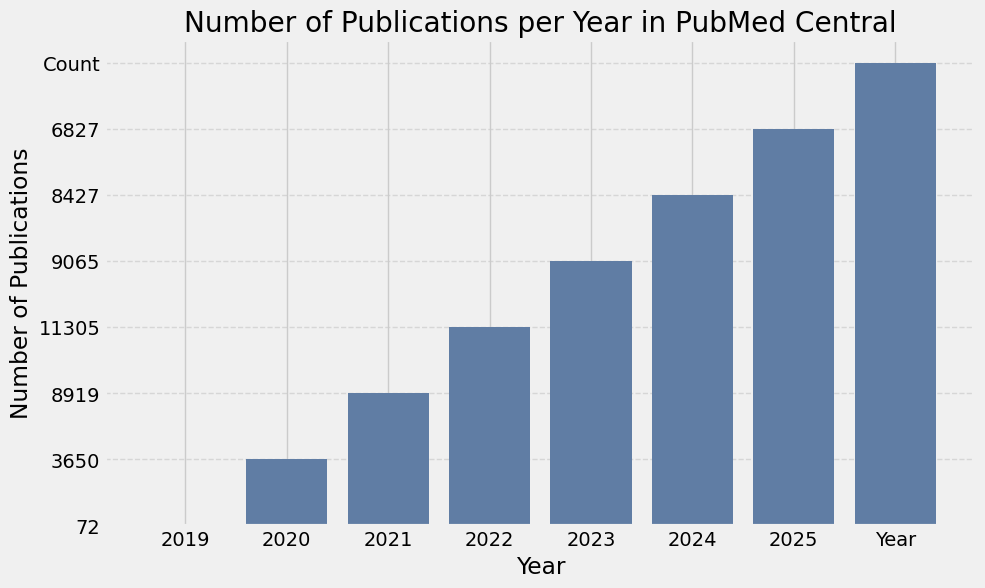

In [220]:
df_publications = pd.read_csv('/Users/fanny/Desktop/Projet_ML/analyses/PubMedCentral_Timeline_Results_by_Year.csv')

# histogramme df_publications, ordre date croissant

df_publications_sorted = df_publications.sort_index()

# Tracer le graphique avec les années dans l'ordre croissant
plt.figure(figsize=(10,6))
plt.bar(df_publications_sorted.index, df_publications_sorted['Search query: covid 19 machine learning models'], color="#607DA4")
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Number of Publications per Year in PubMed Central')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


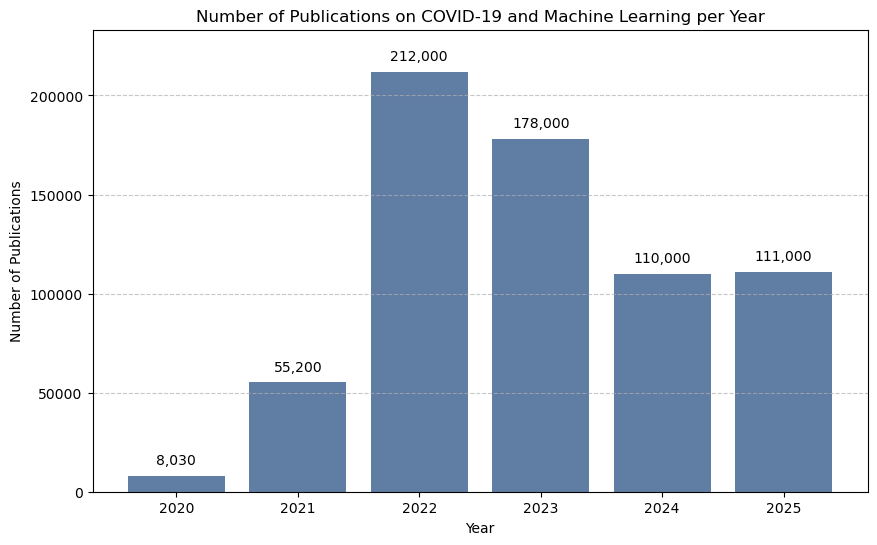

In [227]:
# Données corrigées par année
years = [2020, 2021, 2022, 2023, 2024, 2025]
publications = [8030, 55200, 212000, 178000, 110000, 111000]

# Créer l'histogramme
plt.figure(figsize=(10,6))
plt.bar(years, publications, color="#607DA4")
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('Number of Publications on COVID-19 and Machine Learning per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Augmenter l'axe y pour plus de visibilité
plt.ylim(0, max(publications)*1.1)  # 20% au-dessus de la barre la plus haute

# Ajouter les valeurs au-dessus des barres
for i, pub in enumerate(publications):
    plt.text(years[i], pub + max(publications)*0.02, f"{pub:,}", ha='center', va='bottom')

plt.show()

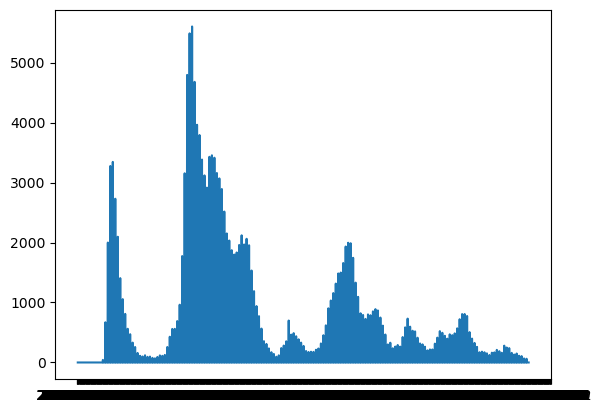

In [ ]:
df_france = df[df['country'] == 'France']
plt.plot(df_france['date'], df_france['new_deaths']) 

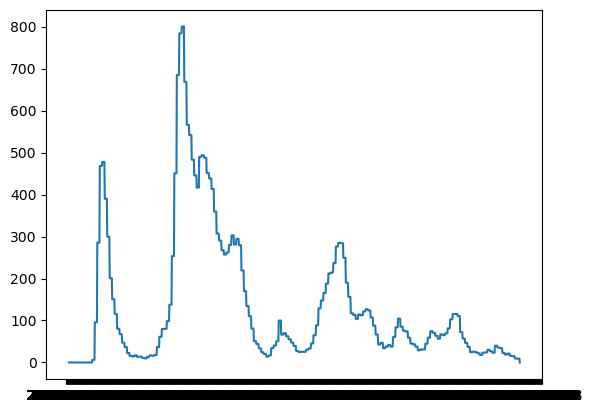

In [52]:
plt.plot(df_france['date'], df_france['new_deaths_smoothed']) 

In [228]:
df_weekly_france

new_cases  new_deaths  new_tests  new_vaccinations  hosp_patients  \
date                                                                            
2020-09-06    50197.0       126.0  1153183.0            4977.0    4629.428571   
2020-09-13    61432.0       258.0  1365371.0            4977.0    5061.857143   
2020-09-20    73481.0       429.0  1401487.0            4977.0    5630.428571   
2020-09-27    72509.0       559.0  1185597.0            4977.0    5971.142857   
2020-10-04    74819.0       561.0  1113751.0            4977.0    6647.000000   
...               ...         ...        ...               ...            ...   
2022-11-27   293632.0       455.0  1255989.0          200901.0   18303.428571   
2022-12-04   384070.0       485.0  1255989.0          275980.0   19501.142857   
2022-12-11   429679.0       569.0  1255989.0          443930.0   21398.857143   
2022-12-18   391192.0       721.0  1255989.0          537008.0   23796.142857   
2022-12-25   299842.0       807.0  1255989.0          297545.0   25096.857143   

            icu_patients  stringency_index  reproduction_rate  total_cases  \
date                                                                         
2020-09-06    448.857143         48.015714           1.327271     180767.0   
2020-09-13    606.428571         48.610000           1.256357     242199.0   
2020-09-20    789.571429         48.610000           1.221043     315680.0   
2020-09-27   1028.714286         47.818571           1.182786     388189.0   
2020-10-04   1248.714286         49.540000           1.154114     463008.0   
...                  ...               ...                ...          ...   
2022-11-27    993.000000         11.110000           1.284171   36484764.0   
2022-12-04   1091.285714         11.110000           1.270386   36868834.0   
2022-12-11   1162.857143         11.110000           1.159214   37298513.0   
2022-12-18   1342.428571         11.110000           1.009357   37689705.0   
2022-12-25   1442.285714         11.110000           0.849114   37989547.0   

            total_tests  ...  lag_7  lag_14  rolling_mean_3  rolling_std_3  \
date                     ...                                                 
2020-09-06    8194778.0  ...    NaN     NaN             NaN            NaN   
2020-09-13    9560149.0  ...    NaN     NaN             NaN            NaN   
2020-09-20   10961636.0  ...    NaN     NaN      271.000000     151.917741   
2020-09-27   12147233.0  ...    NaN     NaN      415.333333     150.964676   
2020-10-04   13260984.0  ...    NaN     NaN      516.333333      75.639496   
...                 ...  ...    ...     ...             ...            ...   
2022-11-27  278234000.0  ...  314.0   413.0      440.333333      38.175035   
2022-12-04  278234000.0  ...  414.0   317.0      469.666667      15.011107   
2022-12-11  278234000.0  ...  522.0   302.0      503.000000      59.093147   
2022-12-18  278234000.0  ...  495.0   263.0      591.666667     119.621626   
2022-12-25  278234000.0  ...  445.0   202.0      699.000000     120.515559   

            rolling_mean_7  rolling_std_7  day_of_week  months  target_t_plus  \
date                                                                            
2020-09-06             NaN            NaN            6       9          258.0   
2020-09-13             NaN            NaN            6       9          429.0   
2020-09-20             NaN            NaN            6       9          559.0   
2020-09-27             NaN            NaN            6       9          561.0   
2020-10-04             NaN            NaN            6      10          690.0   
...                    ...            ...          ...     ...            ...   
2022-11-27      456.714286      43.607011            6      11          485.0   
2022-12-04      466.857143      40.134892            6      12          569.0   
2022-12-11      473.571429      52.823155            6      12          721.0   
2022-12-18      505.857143     108.17

## Pre-processing et forecasting uniquement sur l'Europe

In [122]:
european_countries = [
    "France", "Germany", "Italy", "Spain", "Portugal", "Belgium", "Netherlands",
    "Luxembourg", "Switzerland", "Austria", "Poland",
    "Slovakia", "Hungary", "Slovenia", "Croatia", "Bosnia and Herzegovina",
    "Serbia", "Montenegro", "Greece", "Bulgaria", "Romania", "Moldova", "Ukraine", "Belarus", "Lithuania",
    "Latvia", "Estonia", "Norway", "Sweden", "Finland", "Denmark", "Iceland",
    "Ireland", "United Kingdom", "Cyprus"
]

df_europe = df[df["country"].isin(european_countries)]

df_europe['date'] = pd.to_datetime(df_europe['date'])

# changer le fichier csv en txt avec la liste des pays européens
# df_europe.to_csv('/Users/fanny/Desktop/Projet_ML/data/df_europe.txt', index=False)  

#mettre 0 à la place les NaN

#df_europe = df_europe.fillna(0)

#df_europe.to_csv('/Users/fanny/Desktop/Projet_ML/data/df_europe.csv', index=False)


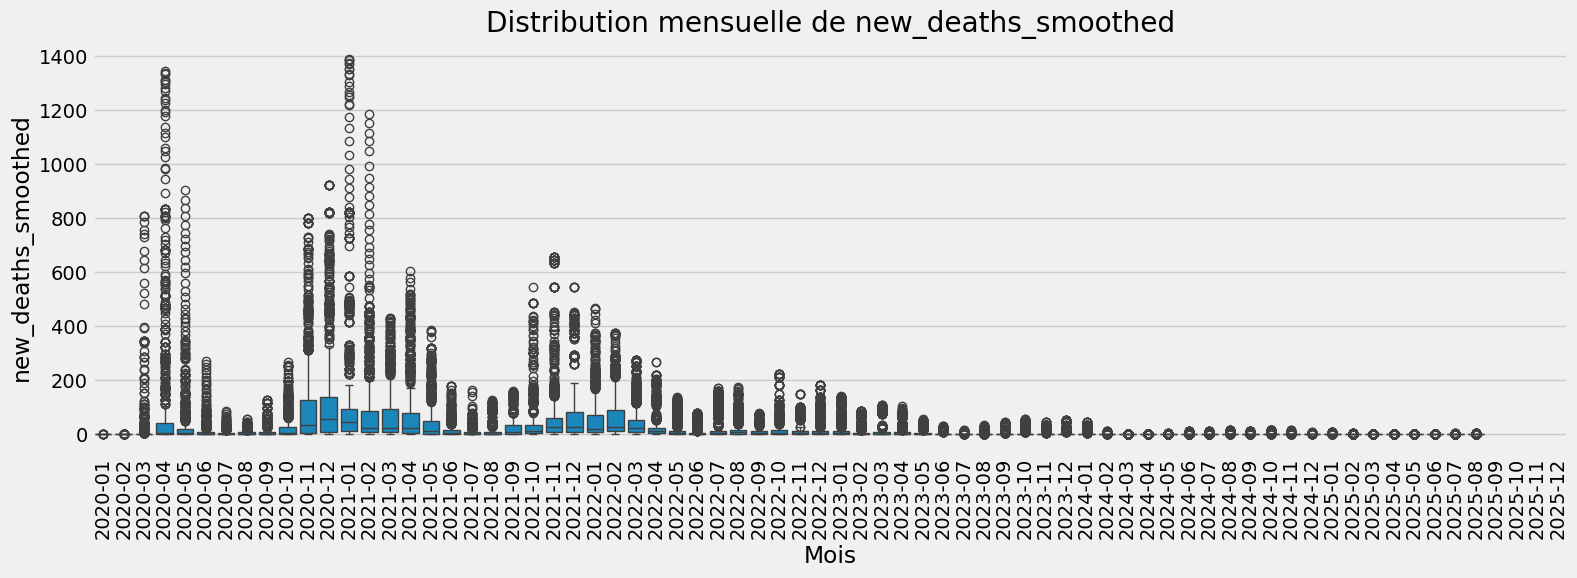

In [4]:
feature = 'new_deaths_smoothed'
df_europe['month'] = df_europe['date'].dt.to_period('M').astype(str)

plt.figure(figsize=(16,6))
sns.boxplot(x='month', y=feature, data=df_europe)
plt.xticks(rotation=90)
plt.title(f"Distribution mensuelle de {feature}")
plt.xlabel("Mois")
plt.ylabel(feature)
plt.tight_layout()
plt.show()

In [128]:
# --- Filtrage du DataFrame ---
df_europe = df[df["country"].isin(european_countries)].copy()

# Conversion en datetime
df_europe["date"] = pd.to_datetime(df_europe["date"])

# Filtrer entre 01/02/2020 et fin 2022
df_europe = df_europe[(df_europe["date"] >= "2020-02-01") & (df_europe["date"] <= "2022-12-31")]

# Colonnes d’intérêt
features = [
    "new_deaths_smoothed", "new_cases_smoothed", "hosp_patients", "icu_patients",
    "stringency_index", "reproduction_rate", "new_tests_smoothed",
    "people_vaccinated", "people_fully_vaccinated", "total_boosters",
    "population_density", "population", "median_age", "life_expectancy",
    "gdp_per_capita", "diabetes_prevalence", "hospital_beds_per_thousand", "new_deaths",
    "new_cases", "total_cases", "total_deaths", "total_tests", "total_vaccinations", "new_tests", "new_vaccinations"
]

df_europe = df_europe[["country", "date"] + features]

#df_europe = df_europe.fillna(0)
#df_europe.to_csv('/Users/fanny/Desktop/Projet_ML/data/df_europe.csv', index=False)


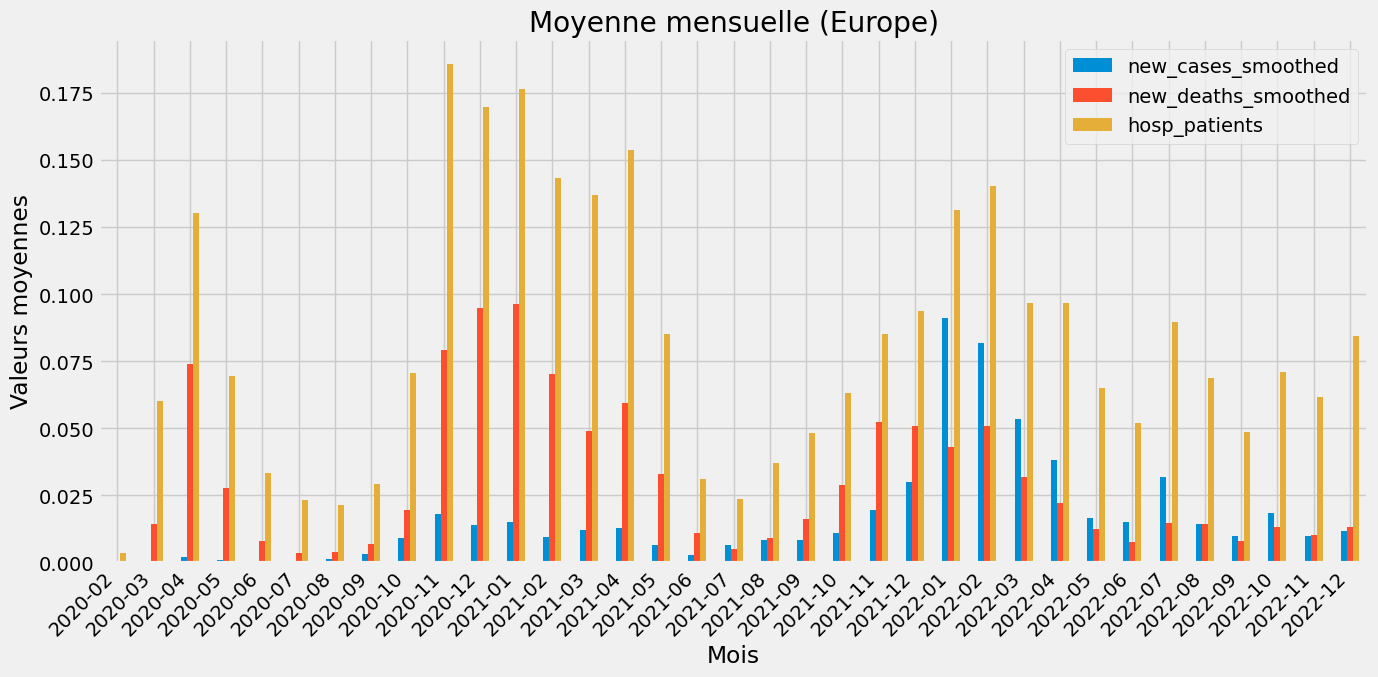

In [6]:
#scaleur des features
scaler = MinMaxScaler()
df_europe[features] = scaler.fit_transform(df_europe[features]) # fit_transform sur le training set normalement et transform sur le test set
#ici on le fait sur tout le dataset pour l'instant

# Ajouter une colonne "year_month" pour regrouper par mois
df_europe["year_month"] = df_europe["date"].dt.to_period("M")

# Moyenne mensuelle pour toutes les features
monthly_mean_all = df_europe.groupby("year_month")[features].mean()

# Histogramme empilé pour 2-3 features par exemple
monthly_mean_all[["new_cases_smoothed", "new_deaths_smoothed", "hosp_patients"]].plot(
    kind="bar", figsize=(14,7)
)

plt.title("Moyenne mensuelle (Europe)")
plt.xlabel("Mois")
plt.ylabel("Valeurs moyennes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#plus de morts que de cas ?



In [6]:
nan_ratio = df_europe.isna().mean().sort_values(ascending=False)
print(nan_ratio)


total_boosters                0.693307
people_fully_vaccinated       0.635439
people_vaccinated             0.618243
total_vaccinations            0.599142
icu_patients                  0.517264
hosp_patients                 0.438954
total_tests                   0.384279
new_tests_smoothed            0.280563
reproduction_rate             0.040107
stringency_index              0.028571
diabetes_prevalence           0.000000
total_deaths                  0.000000
total_cases                   0.000000
new_cases                     0.000000
new_deaths                    0.000000
hospital_beds_per_thousand    0.000000
country                       0.000000
gdp_per_capita                0.000000
life_expectancy               0.000000
median_age                    0.000000
population                    0.000000
date                          0.000000
new_cases_smoothed            0.000000
new_deaths_smoothed           0.000000
population_density            0.000000
dtype: float64


In [131]:
# 1. Vaccins et boosters
for col in ["people_vaccinated", "people_fully_vaccinated", "total_boosters"]:
    df_europe[col] = df_europe[col].fillna(0).interpolate()

# Hosp / ICU patients : interpolation + ffill/bfill + mean par pays
for col in ["hosp_patients", "icu_patients"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (tous les jours NaN pour ce pays), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())

# Autres variables temporelles : interpolation + ffill/bfill + mean par pays
for col in ["new_tests_smoothed", "reproduction_rate", "stringency_index", "total_vaccinations", "total_tests", "new_tests", "new_vaccinations"]:
    # interpolation et propagation
    df_europe[col] = df_europe.groupby("country")[col].transform(
        lambda x: x.interpolate().fillna(method="ffill").fillna(method="bfill")
    )
    # Si il reste encore des NaN (pays sans données du tout), remplacer par moyenne globale
    df_europe[col] = df_europe[col].fillna(df_europe[col].mean())



In [132]:
df_europe.isna().sum()

country                       0
date                          0
new_deaths_smoothed           0
new_cases_smoothed            0
hosp_patients                 0
icu_patients                  0
stringency_index              0
reproduction_rate             0
new_tests_smoothed            0
people_vaccinated             0
people_fully_vaccinated       0
total_boosters                0
population_density            0
population                    0
median_age                    0
life_expectancy               0
gdp_per_capita                0
diabetes_prevalence           0
hospital_beds_per_thousand    0
new_deaths                    0
new_cases                     0
total_cases                   0
total_deaths                  0
total_tests                   0
total_vaccinations            0
new_tests                     0
new_vaccinations              0
dtype: int64

In [21]:

# Calculer la variance pour toutes les features
X = df_europe[features] # NaN déjà imputés
selector = VarianceThreshold(threshold=0.01)  # seuil minimal de variance
selector.fit(X)

# Features retenues
selected_features = X.columns[selector.get_support()]
print("Features avec variance suffisante :", list(selected_features))

fig, ax = plt.subplots(figsize=(12,6))

x = X.columns
y = X.var().values

ax.bar(x, y)
ax.set_xlabel("Features")
ax.set_ylabel("Variance")
ax.set_ylim(0,0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()

Features avec variance suffisante : ['new_deaths_smoothed', 'new_cases_smoothed', 'hosp_patients', 'icu_patients', 'stringency_index', 'reproduction_rate', 'new_tests_smoothed', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'population_density', 'population', 'median_age', 'life_expectancy', 'gdp_per_capita', 'diabetes_prevalence', 'hospital_beds_per_thousand', 'new_deaths', 'new_cases', 'total_cases', 'total_deaths', 'total_tests', 'total_vaccinations']


TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. matplotlib.backends._backend_agg.RendererAgg(width: int, height: int, dpi: float)

Invoked with: 1203, 103748244922700320, 100.0

<Figure size 1200x600 with 1 Axes>

## Agrégation de tous les pays

In [9]:
# Colonnes à sommer (totaux)
sum_cols = [
    "new_deaths", "new_cases", "total_cases", "total_deaths",
    "total_tests", "total_vaccinations", "hosp_patients", "icu_patients",
    "people_vaccinated", "people_fully_vaccinated", "total_boosters"
]

# Colonnes à moyenne pondérée par population
weighted_mean_cols = [
    "new_deaths_smoothed", "new_cases_smoothed",
    "stringency_index", "reproduction_rate",
    "median_age", "life_expectancy", "gdp_per_capita",
    "diabetes_prevalence", "hospital_beds_per_thousand"
]

# Fonction pour moyenne pondérée : 
def weighted_mean(x, col):
    return np.average(x[col], weights=x["population"])

# Groupe par date
agg_list = {}

for col in sum_cols:
    agg_list[col] = "sum"

for col in weighted_mean_cols:
    agg_list[col] = lambda x, c=col: weighted_mean(x, c)

# Agrégation
df_europe_agg = df_europe.groupby("date").agg(agg_list).reset_index()


KeyError: 'new_deaths_smoothed'

In [21]:
df_europe

country       date  new_deaths_smoothed  new_cases_smoothed  \
31008          Austria 2020-02-01              0.00000              0.0000   
31009          Austria 2020-02-02              0.00000              0.0000   
31010          Austria 2020-02-03              0.00000              0.0000   
31011          Austria 2020-02-04              0.00000              0.0000   
31012          Austria 2020-02-05              0.00000              0.0000   
...                ...        ...                  ...                 ...   
489373  United Kingdom 2022-12-27            121.00000           6564.2856   
489374  United Kingdom 2022-12-28            123.00000           5975.2856   
489375  United Kingdom 2022-12-29            127.14286           5685.8570   
489376  United Kingdom 2022-12-30            130.57143           5774.0000   
489377  United Kingdom 2022-12-31            133.28572           5894.1430   

        hosp_patients  icu_patients  stringency_index  reproduction_rate  \
31008          1071.0         215.0              0.00             2.8046   
31009          1071.0         215.0              0.00             2.8046   
31010          1071.0         215.0              0.00             2.8046   
31011          1071.0         215.0              0.00             2.8046   
31012          1071.0         215.0              0.00             2.8046   
...               ...           ...               ...                ...   
489373        11306.0         175.0              5.56             0.3378   
489374        11538.0         175.0              5.56             0.3026   
489375        11670.0         175.0              5.56             0.2730   
489376        11722.0         175.0              5.56             0.2776   
489377        11584.0         175.0              5.56             0.2875   

        new_tests_smoothed  people_vaccinated  ...  life_expectancy  \
31008              14846.0                0.0  ...        81.295898   
31009              14846.0                0.0  ...        81.295898   
31010              14846.0                0.0  ...        81.295898   
31011              14846.0                0.0  ...        81.295898   
31012              14846.0                0.0  ...        81.295898   
...                    ...                ...  ...              ...   
489373            259329.0                0.0  ...        81.074402   
489374            259329.0                0.0  ...        81.074402   
489375            259329.0                0.0  ...        81.074402   
489376            259329.0                0.0  ...        81.074402   
489377            259329.0                0.0  ...        81.074402   

        gdp_per_capita  diabetes_prevalence  hospital_beds_per_thousand  \
31008     55867.183594                  4.6                        7.27   
31009     55867.183594                  4.6                        7.27   
31010     55867.183594                  4.6                        7.27   
31011     55867.183594                  4.6                        7.27   
31012     55867.183594                  4.6                        7.27   
...                ...                  ...                         ...   
489373    47587.167969                  6.3                        2.46   
489374    47587.167969                  6.3                        2.46   
489375    47587.167969                  6.3                        2.46   
489376    47587.167969                  6.3                        2.46   
489377    47587.167969                  6.3                        2.46   

        new_deaths  new_cases  total_cases  total_deaths  total_tests  \
31008          0.0        0.0          0.0           0.0      16834.0   
31009          0.0        0.0          0.0           0.0      16834.0   
31010          0.0        0.0          0.0           0.0      16834.0   
31011          0.0        0.0          0.0           0.0      16834.0   
31012          0.0        0.0          0.0    

## Baseline model

In [ ]:

# X = features, y = target continue
features_corrected = [f for f in features if f != "new_deaths_smoothed"]
X = df_europe[features_corrected].values
y = df_europe["new_deaths_smoothed"].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline LASSO avec standardisation
lasso_pipeline = make_pipeline( 
    StandardScaler(),  # standardise chaque feature (mean=0, std=1)
    LassoCV(cv=5, random_state=42)  # LASSO avec cross-validation pour alpha
)
# Entraînement
lasso_pipeline.fit(X_train, y_train)

# Prédiction
y_pred = lasso_pipeline.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"LASSO -> MSE: {mse:.4f}, R2: {r2:.4f}")

lasso_model = lasso_pipeline.named_steps["lassocv"]

# Créer DataFrame avec les bonnes features
coef_df = pd.DataFrame({
    "Feature": features_corrected,
    "Coefficient": lasso_model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(coef_df)


LASSO -> MSE: 3476.7012, R2: 0.6950
                       Feature  Coefficient
1                hosp_patients    36.798584
6            people_vaccinated   -33.791074
2                 icu_patients    26.901071
16                  new_deaths    25.537455
19                total_deaths    23.157277
18                 total_cases   -17.870990
8               total_boosters    17.470615
10                  population    13.766813
7      people_fully_vaccinated    12.646960
17                   new_cases    -9.861746
21          total_vaccinations    -8.795780
13              gdp_per_capita     8.532249
12             life_expectancy    -7.502872
3             stringency_index     7.330379
0           new_cases_smoothed     7.027520
4            reproduction_rate    -6.260946
15  hospital_beds_per_thousand    -5.610016
11                  median_age     5.298327
20                 total_tests    -5.021937
9           population_density     4.383316
14         diabetes_prevalence    -0.711

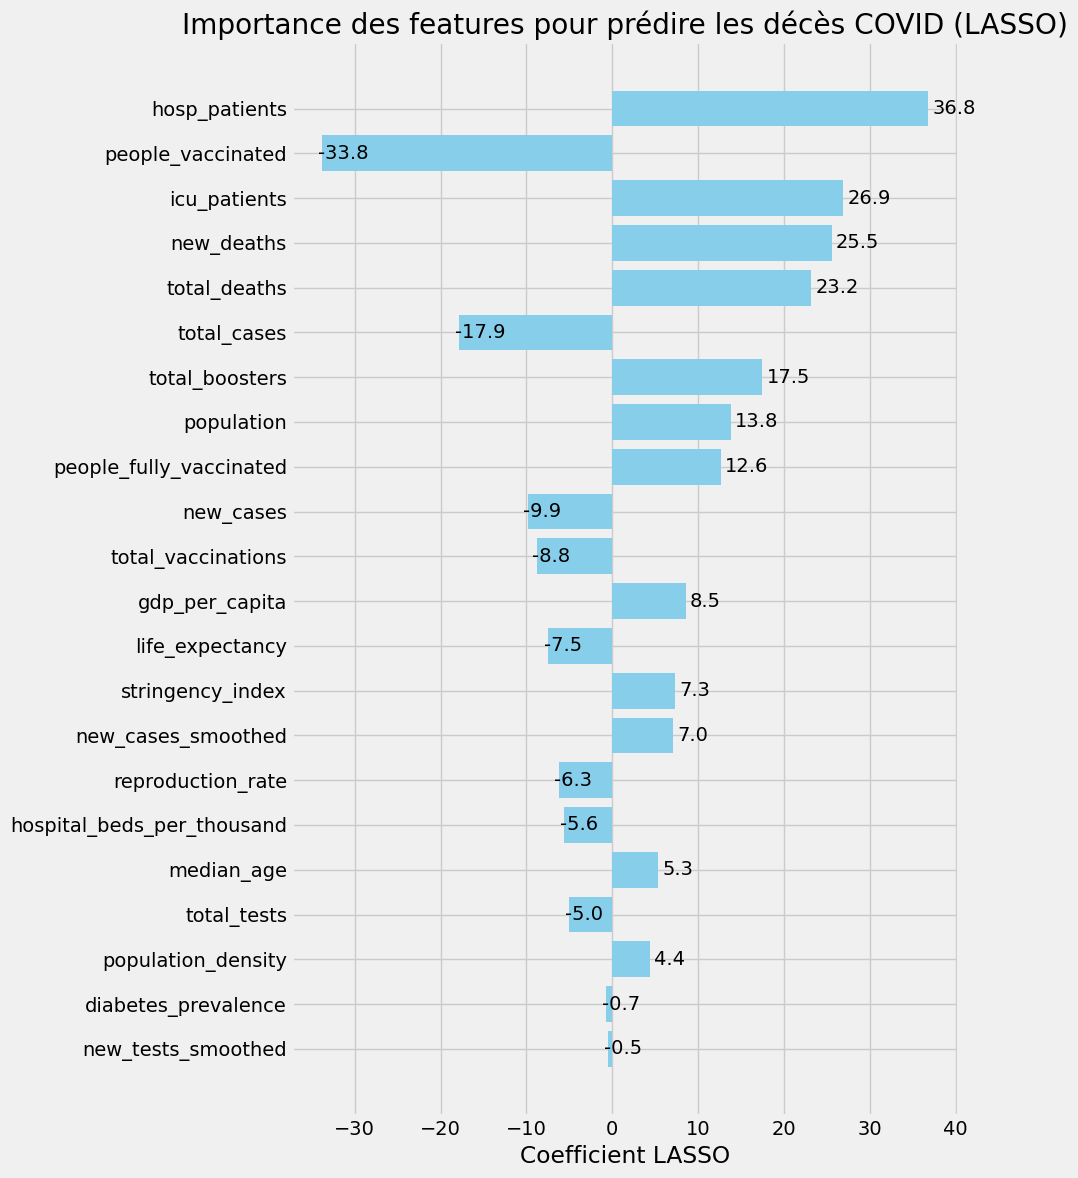

In [ ]:
# Trier par importance absolue
coef_df_sorted = coef_df.copy()
coef_df_sorted["abs_coef"] = coef_df_sorted["Coefficient"].abs()
coef_df_sorted = coef_df_sorted.sort_values(by="abs_coef", ascending=True)

# Figure
fig, ax = plt.subplots(figsize=(10, 12))

# Bar plot horizontal
ax.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"], color="skyblue")
ax.set_xlabel("Coefficient LASSO")
ax.set_title("Importance des features pour prédire les décès COVID (LASSO)")

# Ajouter valeurs sur les barres
for i, (coef, feat) in enumerate(zip(coef_df_sorted["Coefficient"], coef_df_sorted["Feature"])):
    ax.text(coef + np.sign(coef)*0.5, i, f"{coef:.1f}", va="center")

plt.tight_layout()
plt.show()

In [ ]:
windows = 3, 7, 14
cols = ["new_deaths_smoothed", "new_cases_smoothed", "new_tests_smoothed", "hosp_patients", "icu_patients"]

# for col in cols:
#         if col in df_europe.columns:
#             for window in windows:
#                 df_europe[f'{col}_ma_{window}'] = df_europe[col].rolling(window=window, min_periods=1).mean()
#                 df_europe[f'{col}_std_{window}'] = df_europe[col].rolling(window=window, min_periods=1).std()
#                 df_europe[f'{col}_max_{window}'] = df_europe[col].rolling(window=window, min_periods=1).max()
#                 df_europe[f'{col}_min_{window}'] = df_europe[col].rolling(window=window, min_periods=1).min()

for col in cols:
    if col in df_europe.columns:
        for window in windows:
            # Calcul expansion pour les premières valeurs
            expanding_mean = df_europe[col].expanding().mean()
            expanding_std = df_europe[col].expanding().std()
            expanding_max = df_europe[col].expanding().max()
            expanding_min = df_europe[col].expanding().min()

            # Calcul rolling normal
            rolling_mean = df_europe[col].rolling(window=window).mean()
            rolling_std = df_europe[col].rolling(window=window).std()
            rolling_max = df_europe[col].rolling(window=window).max()
            rolling_min = df_europe[col].rolling(window=window).min()

            # Combiner: expansion au début, rolling après
            df_europe[f'{col}_ma_{window}'] = rolling_mean.fillna(expanding_mean)
            df_europe[f'{col}_std_{window}'] = rolling_std.fillna(expanding_std)
            df_europe[f'{col}_max_{window}'] = rolling_max.fillna(expanding_max)
            df_europe[f'{col}_min_{window}'] = rolling_min.fillna(expanding_min)

In [ ]:
df_europe.fillna(0)


country       date  new_deaths_smoothed  new_cases_smoothed  \
31008          Austria 2020-02-01              0.00000              0.0000   
31009          Austria 2020-02-02              0.00000              0.0000   
31010          Austria 2020-02-03              0.00000              0.0000   
31011          Austria 2020-02-04              0.00000              0.0000   
31012          Austria 2020-02-05              0.00000              0.0000   
...                ...        ...                  ...                 ...   
489373  United Kingdom 2022-12-27            121.00000           6564.2856   
489374  United Kingdom 2022-12-28            123.00000           5975.2856   
489375  United Kingdom 2022-12-29            127.14286           5685.8570   
489376  United Kingdom 2022-12-30            130.57143           5774.0000   
489377  United Kingdom 2022-12-31            133.28572           5894.1430   

        hosp_patients  icu_patients  stringency_index  reproduction_rate  \
31008          1071.0         215.0              0.00             2.8046   
31009          1071.0         215.0              0.00             2.8046   
31010          1071.0         215.0              0.00             2.8046   
31011          1071.0         215.0              0.00             2.8046   
31012          1071.0         215.0              0.00             2.8046   
...               ...           ...               ...                ...   
489373        11306.0         175.0              5.56             0.3378   
489374        11538.0         175.0              5.56             0.3026   
489375        11670.0         175.0              5.56             0.2730   
489376        11722.0         175.0              5.56             0.2776   
489377        11584.0         175.0              5.56             0.2875   

        new_tests_smoothed  people_vaccinated  ...  icu_patients_max_3  \
31008              14846.0                0.0  ...               215.0   
31009              14846.0                0.0  ...               215.0   
31010              14846.0                0.0  ...               215.0   
31011              14846.0                0.0  ...               215.0   
31012              14846.0                0.0  ...               215.0   
...                    ...                ...  ...                 ...   
489373            259329.0                0.0  ...               175.0   
489374            259329.0                0.0  ...               175.0   
489375            259329.0                0.0  ...               175.0   
489376            259329.0                0.0  ...               175.0   
489377            259329.0                0.0  ...               175.0   

        icu_patients_min_3  icu_patients_ma_7  icu_patients_std_7  \
31008                215.0              215.0                 0.0   
31009                215.0              215.0                 0.0   
31010                215.0              215.0                 0.0   
31011                215.0              215.0                 0.0   
31012                215.0              215.0                 0.0   
...                    ...                ...                 ...   
489373               175.0              175.0                 0.0   
489374               175.0              175.0                 0.0   
489375               175.0              175.0                 0.0   
489376               175.0              175.0                 0.0   
489377               175.0              175.0                 0.0   

        icu_patients_max_7  icu_patients_min_7  icu_patients_ma_14  \
31008                215.0               215.0               215.0   
31009                215.0               215.0               215.0   
31010                215.0               215.0               215.0   
31011                215.0               215.0               215.0   
31012                215.0               215.0               215.0   
...                    ... 

## Pour la France

In [229]:
# 1. Filtrer la France
df_france = df_europe[df_europe['country'] == 'France'].copy()
df_france['date'] = pd.to_datetime(df_france['date'])
df_france = df_france.set_index('date')

# 2. Définir les colonnes par type
cols_sum = ["new_cases", "new_deaths", "new_tests", "new_vaccinations"]
cols_mean = ["hosp_patients", "icu_patients", "stringency_index", "reproduction_rate",]
cols_last = ["total_cases", "total_tests", "total_vaccinations",
             "people_vaccinated", "total_boosters"]

# 3. Calculer les agrégations
weekly_sum = df_france[cols_sum].resample("W-SUN").sum()
weekly_mean = df_france[cols_mean].resample("W-SUN").mean()
weekly_last = df_france[cols_last].resample("W-SUN").last()

# 4. Combiner tout
df_weekly_france = pd.concat([weekly_sum, weekly_mean, weekly_last], axis=1)
df_weekly_france = df_weekly_france.iloc[:-1, :]
df_weekly_france = df_weekly_france.loc["2020-09":"2022-12"]


# Résultat : un DataFrame hebdomadaire, indexé par les dimanches
print(df_weekly_france.head())


            new_cases  new_deaths  new_tests  new_vaccinations  hosp_patients  \
date                                                                            
2020-09-06    50197.0       126.0  1153183.0            4977.0    4629.428571   
2020-09-13    61432.0       258.0  1365371.0            4977.0    5061.857143   
2020-09-20    73481.0       429.0  1401487.0            4977.0    5630.428571   
2020-09-27    72509.0       559.0  1185597.0            4977.0    5971.142857   
2020-10-04    74819.0       561.0  1113751.0            4977.0    6647.000000   

            icu_patients  stringency_index  reproduction_rate  total_cases  \
date                                                                         
2020-09-06    448.857143         48.015714           1.327271     180767.0   
2020-09-13    606.428571         48.610000           1.256357     242199.0   
2020-09-20    789.571429         48.610000           1.221043     315680.0   
2020-09-27   1028.714286         47.818571

In [230]:
df_weekly_france

new_cases  new_deaths  new_tests  new_vaccinations  hosp_patients  \
date                                                                            
2020-09-06    50197.0       126.0  1153183.0            4977.0    4629.428571   
2020-09-13    61432.0       258.0  1365371.0            4977.0    5061.857143   
2020-09-20    73481.0       429.0  1401487.0            4977.0    5630.428571   
2020-09-27    72509.0       559.0  1185597.0            4977.0    5971.142857   
2020-10-04    74819.0       561.0  1113751.0            4977.0    6647.000000   
...               ...         ...        ...               ...            ...   
2022-11-27   293632.0       455.0  1255989.0          200901.0   18303.428571   
2022-12-04   384070.0       485.0  1255989.0          275980.0   19501.142857   
2022-12-11   429679.0       569.0  1255989.0          443930.0   21398.857143   
2022-12-18   391192.0       721.0  1255989.0          537008.0   23796.142857   
2022-12-25   299842.0       807.0  1255989.0          297545.0   25096.857143   

            icu_patients  stringency_index  reproduction_rate  total_cases  \
date                                                                         
2020-09-06    448.857143         48.015714           1.327271     180767.0   
2020-09-13    606.428571         48.610000           1.256357     242199.0   
2020-09-20    789.571429         48.610000           1.221043     315680.0   
2020-09-27   1028.714286         47.818571           1.182786     388189.0   
2020-10-04   1248.714286         49.540000           1.154114     463008.0   
...                  ...               ...                ...          ...   
2022-11-27    993.000000         11.110000           1.284171   36484764.0   
2022-12-04   1091.285714         11.110000           1.270386   36868834.0   
2022-12-11   1162.857143         11.110000           1.159214   37298513.0   
2022-12-18   1342.428571         11.110000           1.009357   37689705.0   
2022-12-25   1442.285714         11.110000           0.849114   37989547.0   

            total_tests  total_vaccinations  people_vaccinated  total_boosters  
date                                                                            
2020-09-06    8194778.0               616.0                0.0             0.0  
2020-09-13    9560149.0               616.0                0.0             0.0  
2020-09-20   10961636.0               616.0                0.0             0.0  
2020-09-27   12147233.0               616.0                0.0             0.0  
2020-10-04   13260984.0               616.0                0.0             0.0  
...                 ...                 ...                ...             ...  
2022-11-27  278234000.0         151756050.0         54628364.0      45079989.0  
2022-12-04  278234000.0         152032030.0         54631412.0      45349205.0  
2022-12-11  278234000.0         152475950.0         54635052.0      45785165.0  
2022-12-18  278234000.0         153012960.0         54638820.0      46313855.0  
2022-12-25  278234000.0         153310510.0         54642030.0      46604735.0  

[121 rows x 13 columns]

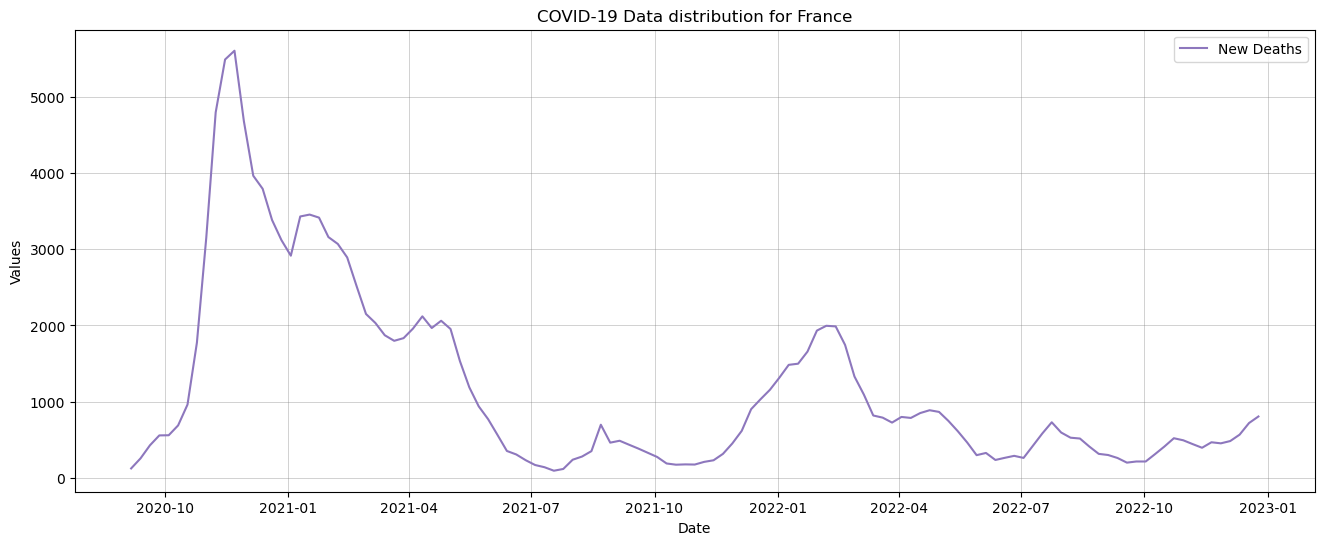

In [157]:
#plot data france
plt.style.use('default') 
plt.figure(figsize=(16,6), facecolor="white")
plt.plot(df_weekly_france.index, df_weekly_france['new_deaths'], label='New Deaths', color='#8D77BD')
ax = plt.gca()
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title('COVID-19 Data distribution for France')
ax.legend()

In [89]:
df_model

new_deaths  new_cases  hosp_patients  icu_patients  \
date                                                             
2020-05-10      1056.0        0.0   23561.428571   3047.428571   
2020-05-17       810.0      677.0   20519.142857   2300.428571   
2020-05-24       562.0     4340.0   17764.571429   1740.571429   
2020-05-31       471.0     3436.0   15282.285714   1408.714286   
2020-06-07       331.0     2745.0   13176.000000   1131.714286   
...                ...        ...            ...           ...   
2022-11-20       469.0   221689.0   17989.571429    968.285714   
2022-11-27       455.0   293632.0   18303.428571    993.000000   
2022-12-04       485.0   384070.0   19501.142857   1091.285714   
2022-12-11       569.0   429679.0   21398.857143   1162.857143   
2022-12-18       721.0   391192.0   23796.142857   1342.428571   

            stringency_index  reproduction_rate  people_vaccinated  \
date                                                                 
2020-05-10         87.960000           0.631000       0.000000e+00   
2020-05-17         76.850000           0.639271       0.000000e+00   
2020-05-24         76.850000           0.891986       0.000000e+00   
2020-05-31         75.264286           1.278743       0.000000e+00   
2020-06-07         72.617143           1.028871       0.000000e+00   
...                      ...                ...                ...   
2022-11-20         11.110000           1.195186       5.462432e+07   
2022-11-27         11.110000           1.284171       5.462732e+07   
2022-12-04         11.110000           1.270386       5.463028e+07   
2022-12-11         11.110000           1.159214       5.463368e+07   
2022-12-18         11.110000           1.009357       5.463746e+07   

            total_boosters  population_density  population  ...   lag_7  \
date                                                        ...           
2020-05-10    0.000000e+00          121.041946  66277365.0  ...   670.0   
2020-05-17    0.000000e+00          121.041946  66277365.0  ...  1999.0   
2020-05-24    0.000000e+00          121.041946  66277365.0  ...  3276.0   
2020-05-31    0.000000e+00          121.041946  66277365.0  ...  3344.0   
2020-06-07    0.000000e+00          121.041946  66277365.0  ...  2730.0   
...                    ...                 ...         ...  ...     ...   
2022-11-20    4.481266e+07          121.041946  66277365.0  ...   217.0   
2022-11-27    4.501328e+07          121.041946  66277365.0  ...   314.0   
2022-12-04    4.524840e+07          121.041946  66277365.0  ...   414.0   
2022-12-11    4.562304e+07          121.041946  66277365.0  ...   522.0   
2022-12-18    4.613306e+07          121.041946  66277365.0  ...   495.0   

            lag_14  rolling_mean_3  rolling_std_3  rolling_mean_7  \
date                                                                
2020-05-10     0.0     1519.333333     529.181758     2272.428571   
2020-05-17     0.0     1090.666667     299.508486     2102.571429   
2020-05-24     0.0      809.333333     247.000675     1714.857143   
2020-05-31     0.0      614.333333     175.454648     1304.428571   
2020-06-07     0.0      454.666667     116.362938      961.714286   
...            ...             ...            ...             ...   
2022-11-20   518.0      437.000000      36.660606      436.571429   
2022-11-27   413.0      440.333333      38.175035      456.714286   
2022-12-04   317.0      469.666667      15.011107      466.857143   
2022-12-11   302.0      503.000000      59.093147      473.571429   
2022-12-18   263.0      591.666667     119.621626      505.857143   

            rolling_std_7  day_of_week  months  target_t_plus  date_t_plus  
date                                                                        
2020-05-10     885.162858            6       5          810.0   2020-05-03  
2020-05-17    1045.869153            6       5          562.0   2020-05-10  
2020-05-24    1041.411131            6       5          471.

In [207]:
# Créer des lags et un horizon de forecast

def feature_engineering(df):
    # Créer des lags pour la target
    df["lag_1"] = df["new_deaths"].shift(1)
    df["lag_2"] = df["new_deaths"].shift(2)
    df["lag_3"] = df["new_deaths"].shift(3)
    df["lag_7"] = df["new_deaths"].shift(7)
    df["lag_14"] = df["new_deaths"].shift(14)

    # Moyennes et écarts-types roulants
    df["rolling_mean_3"] = df["new_deaths"].rolling(window=3).mean()
    df["rolling_std_3"] = df["new_deaths"].rolling(window=3).std()
    df["rolling_mean_7"] = df["new_deaths"].rolling(window=7).mean()
    df["rolling_std_7"] = df["new_deaths"].rolling(window=7).std()

    # Variables temporelles
    df["day_of_week"] = df.index.dayofweek
    df["months"] = df.index.month

    # Horizon de forecast (1 jour dans le futur)
    df["target_t_plus"] = df["new_deaths"].shift(-1)
    df["date_t_plus"] = df.index.shift(-1)

    return df
df_france_augmented = feature_engineering(df_weekly_france)

# Supprimer les lignes qui ont des NaN
df_model = df_france_augmented.dropna()

X = df_model.drop(columns=["date_t_plus","target_t_plus", "new_deaths"])
y = df_model[["date_t_plus", "target_t_plus"]]
#X = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]


In [208]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [160]:
X_train

new_cases  new_tests  new_vaccinations  hosp_patients  \
date                                                                
2020-12-13    77674.0  1336217.0            4977.0   25434.000000   
2020-12-20    92919.0  2341687.0            4977.0   25116.000000   
2020-12-27    83888.0  2971523.0            4977.0   24716.428571   
2021-01-03    88948.0  1810817.0            4003.0   24550.857143   
2021-01-10   122263.0  1992382.0          106438.0   24596.000000   
...               ...        ...               ...            ...   
2022-06-19   297927.0  1541898.0          275311.0   13960.571429   
2022-06-26   456705.0  1255989.0          345716.0   14455.285714   
2022-07-03   731586.0  1255989.0          574992.0   15818.142857   
2022-07-10   903969.0  1255989.0          746446.0   17539.000000   
2022-07-17   683784.0  1255989.0          542940.0   19583.857143   

            icu_patients  stringency_index  reproduction_rate  total_cases  \
date                                                                         
2020-12-13   2976.000000         75.000000           0.934543    2161451.0   
2020-12-20   2804.571429         65.477143           1.028857    2254370.0   
2020-12-27   2672.285714         63.890000           1.032371    2338258.0   
2021-01-03   2649.000000         63.890000           1.083729    2427206.0   
2021-01-10   2611.285714         63.890000           1.136829    2549469.0   
...                  ...               ...                ...          ...   
2022-06-19    845.142857         18.810000           1.118500   29139642.0   
2022-06-26    835.142857         18.810000           1.348043   29596347.0   
2022-07-03    926.714286         18.810000           1.395386   30327933.0   
2022-07-10   1022.285714         18.800000           1.246143   31231902.0   
2022-07-17   1181.857143         18.800000           1.038800   31915686.0   

            total_tests  total_vaccinations  ...   lag_2   lag_3   lag_7  \
date                                         ...                           
2020-12-13   29067653.0               616.0  ...  4679.0  5602.0  1774.0   
2020-12-20   31409340.0               616.0  ...  3963.0  4679.0  3154.0   
2020-12-27   34380863.0               616.0  ...  3792.0  3963.0  4794.0   
2021-01-03   36191680.0              4619.0  ...  3383.0  3792.0  5487.0   
2021-01-10   38184062.0            111057.0  ...  3119.0  3383.0  5602.0   
...                 ...                 ...  ...     ...     ...     ...   
2022-06-19  278234000.0         145487150.0  ...   329.0   300.0   867.0   
2022-06-26  278234000.0         145832860.0  ...   237.0   329.0   749.0   
2022-07-03  278234000.0         146407860.0  ...   265.0   237.0   614.0   
2022-07-10  278234000.0         147154300.0  ...   291.0   265.0   466.0   
2022-07-17  278234000.0         147697250.0  ...   264.0   291.0   300.0   

            lag_14  rolling_mean_3  rolling_std_3  rolling_mean_7  \
date                                                                
2020-12-13   126.0     4144.666667     470.578722     4495.857143   
2020-12-20   258.0     3712.666667     298.027404     4528.571429   
2020-12-27   429.0     3431.333333     339.093399     4289.285714   
2021-01-03   559.0     3139.000000     234.640150     3921.857143   
2021-01-10   561.0     3154.333333     258.815249     3611.428571   
...            ...             ...            ...             ...   
2022-06-19   820.0      277.000000      47.159304      422.857143   
2022-06-26   792.0      264.333333      27.006172      357.428571   
2022-07-03   727.0      273.333333      15.307950      307.428571   
2022-07-10   801.0      326.333333      85.652398      301.428571   
2022-07-17   788.0      424.333333     160.500260      342.142857   

            rolling_std_7  day_of_week  months  
date                                            
2020-12-13     904.459218            6      12  
2020-12-20     850.358524            6      12  
2020-12-27     9

In [161]:
y_train

date_t_plus  target_t_plus
date                                 
2020-12-13  2020-12-06         3383.0
2020-12-20  2020-12-13         3119.0
2020-12-27  2020-12-20         2915.0
2021-01-03  2020-12-27         3429.0
2021-01-10  2021-01-03         3454.0
...                ...            ...
2022-06-19  2022-06-12          291.0
2022-06-26  2022-06-19          264.0
2022-07-03  2022-06-26          424.0
2022-07-10  2022-07-03          585.0
2022-07-17  2022-07-10          731.0

[84 rows x 2 columns]

In [197]:
tscv = TimeSeriesSplit(n_splits=3)

rf_france_model = RandomForestRegressor()
rf_scores = cross_val_score(rf_france_model, X, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
print("Random Forest - RMSE pour chaque split :", -rf_scores)
print("Random Forest - RMSE moyen :", -rf_scores.mean())

rf_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = rf_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"Random Forest France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

Random Forest - RMSE pour chaque split : [400.17345197 460.46767705  94.2703983 ]
Random Forest - RMSE moyen : 318.30384243784624
Random Forest France -> RMSE: 101.5548, R2: 0.5658


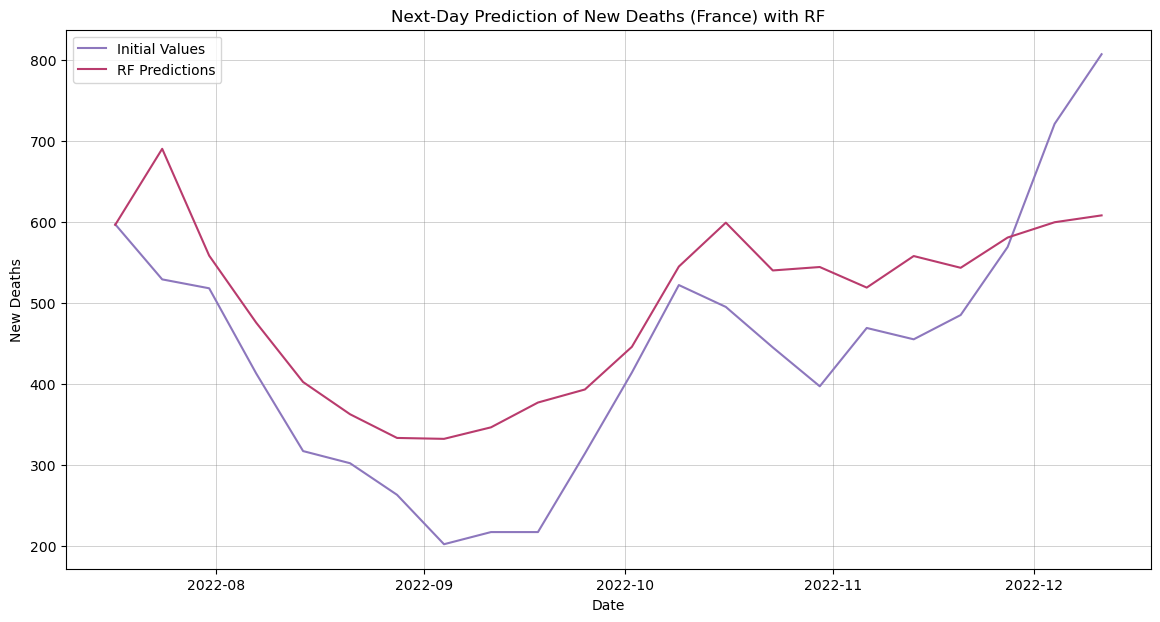

In [198]:
# plot des résultats


plt.figure(figsize=(14,7), facecolor="white")
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Initial Values', color='#8D77BD')
plt.plot(y_test['date_t_plus'], y_pred_france, label='RF Predictions', color="#B93B6D")
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.set_title('Next-Day Prediction of New Deaths (France) with RF')
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.legend()
plt.show()

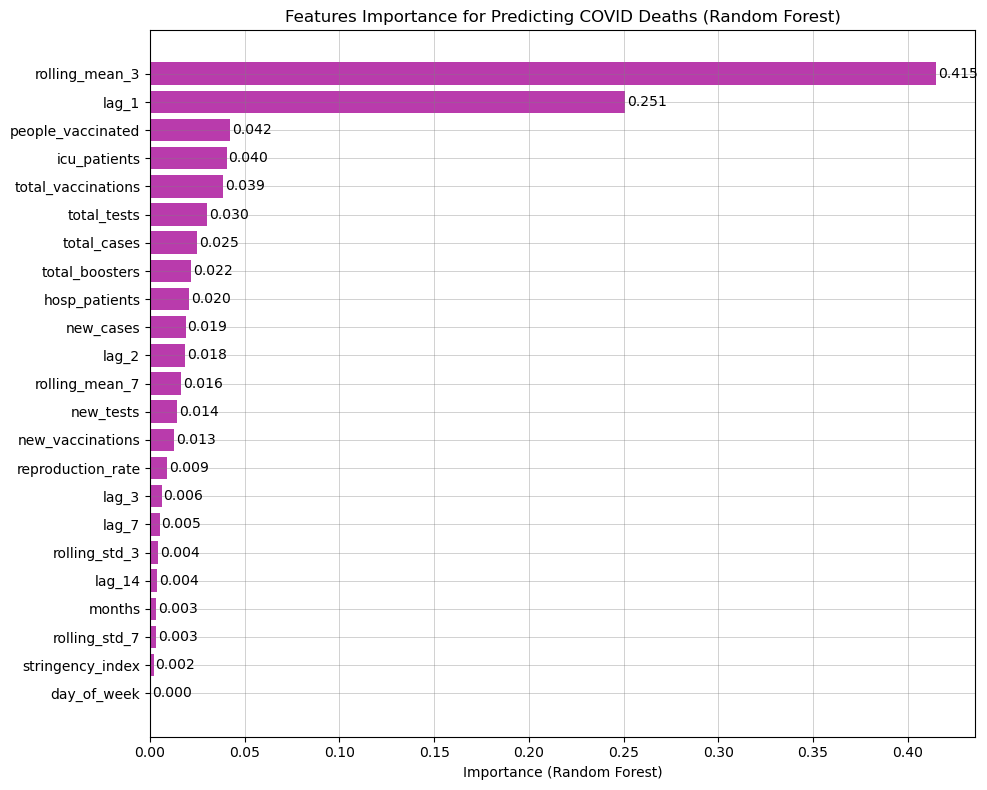

In [187]:
# Extraire les importances des features du Random Forest
feature_importances = rf_france_model.feature_importances_

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
})

# Trier par importance absolue (ici elles sont déjà positives mais on garde la logique)
coef_df_sorted = coef_df.sort_values(by="Importance", ascending=True)

# Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Bar plot horizontal
ax.barh(coef_df_sorted["Feature"], coef_df_sorted["Importance"], color="#B93BAC")
ax.set_xlabel("Importance (Random Forest)")
ax.set_title("Features Importance for Predicting COVID Deaths (Random Forest)")
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)


# Ajouter valeurs sur les barres
for i, (imp, feat) in enumerate(zip(coef_df_sorted["Importance"], coef_df_sorted["Feature"])):
    ax.text(imp + 0.001, i, f"{imp:.3f}", va="center")

plt.tight_layout()

plt.show()


## avec que les lags

Random Forest - RMSE pour chaque split : [266.38459599 533.02476596 168.53511152]
Random Forest - RMSE moyen : 322.64815782542905
Random Forest France -> RMSE: 104.7072, R2: 0.5384


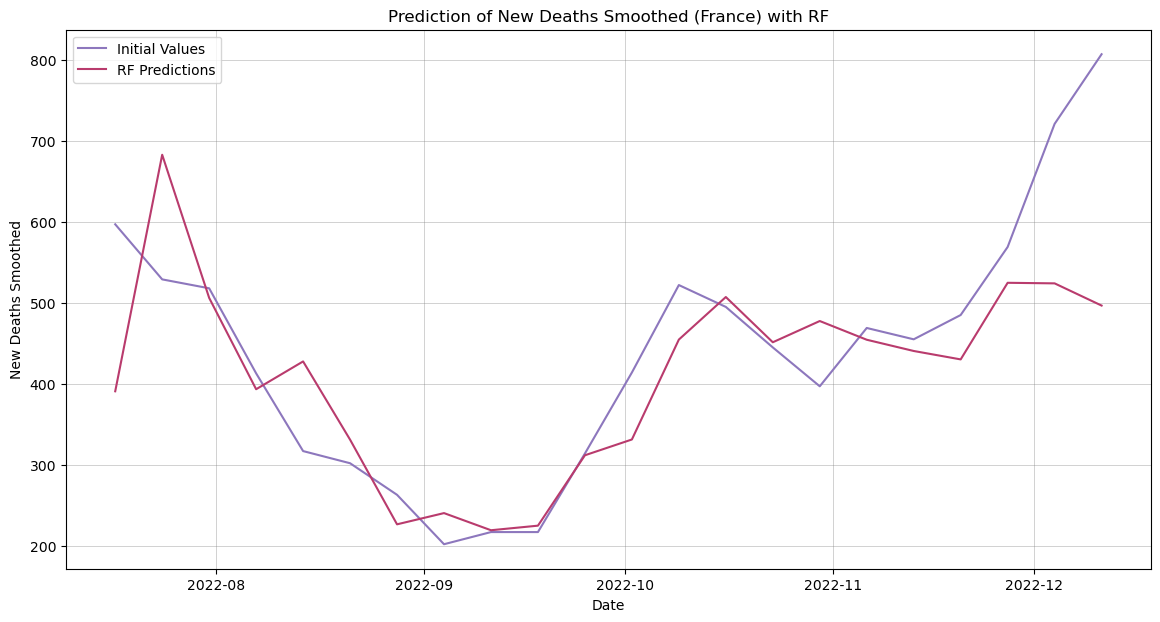

In [166]:
X_lags = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

train_size = int(len(X) * 0.8)
X_train, X_test = X_lags.iloc[:train_size], X_lags.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

tscv = TimeSeriesSplit(n_splits=3)

rf_france_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_scores = cross_val_score(rf_france_model, X_lags, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
print("Random Forest - RMSE pour chaque split :", -rf_scores)
print("Random Forest - RMSE moyen :", -rf_scores.mean())

rf_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = rf_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"Random Forest France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

# plot des résultats
plt.figure(figsize=(14,7), facecolor="white")
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Initial Values', color='#8D77BD')
plt.plot(y_test['date_t_plus'], y_pred_france, label='RF Predictions', color="#B93B6D")
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths Smoothed')
ax.set_title('Prediction of New Deaths Smoothed (France) with RF')
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.legend()
plt.show()


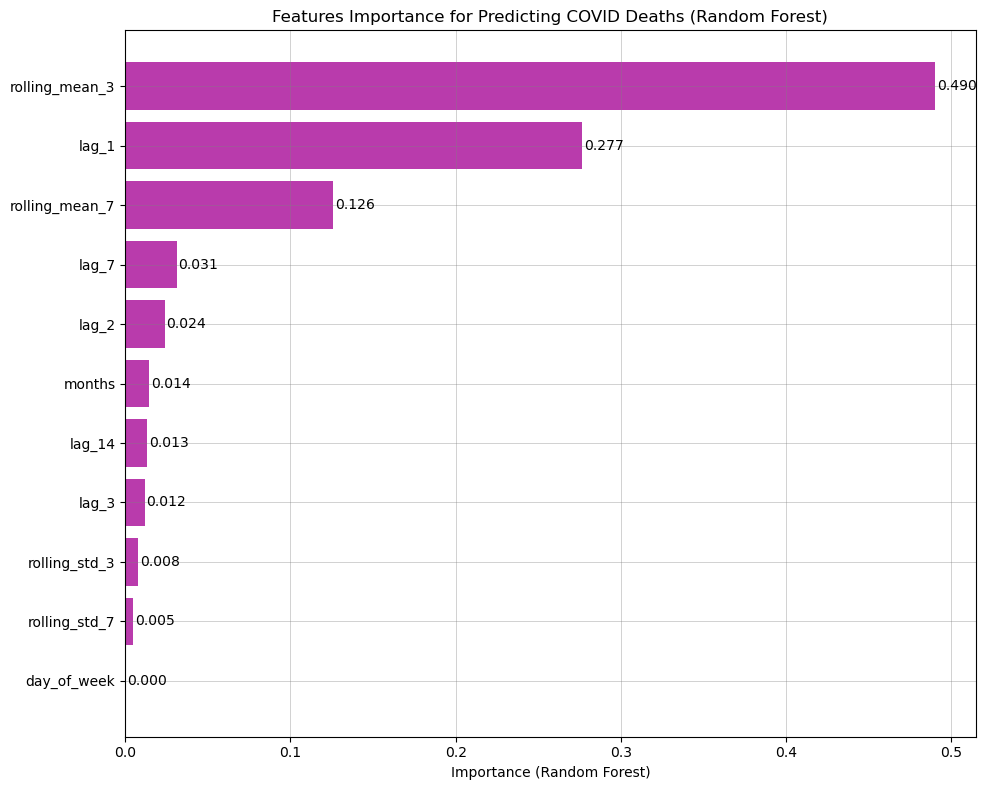

In [168]:
# Extraire les importances des features du Random Forest
feature_importances = rf_france_model.feature_importances_

coef_df = pd.DataFrame({
    "Feature": X_lags.columns,
    "Importance": feature_importances
})

# Trier par importance absolue (ici elles sont déjà positives mais on garde la logique)
coef_df_sorted = coef_df.sort_values(by="Importance", ascending=True)

# Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Bar plot horizontal
ax.barh(coef_df_sorted["Feature"], coef_df_sorted["Importance"], color="#B93BAC")
ax.set_xlabel("Importance (Random Forest)")
ax.set_title("Features Importance for Predicting COVID Deaths (Random Forest)")
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)


# Ajouter valeurs sur les barres
for i, (imp, feat) in enumerate(zip(coef_df_sorted["Importance"], coef_df_sorted["Feature"])):
    ax.text(imp + 0.001, i, f"{imp:.3f}", va="center")

plt.tight_layout()
plt.show()


## XGBoost

XGBoost - RMSE pour chaque split : [1028.69526781  474.66159325  174.5206911 ]
XGBoost - RMSE moyen : 559.2925173879886
XGBoost France -> RMSE: 221.5520, R2: -1.0666


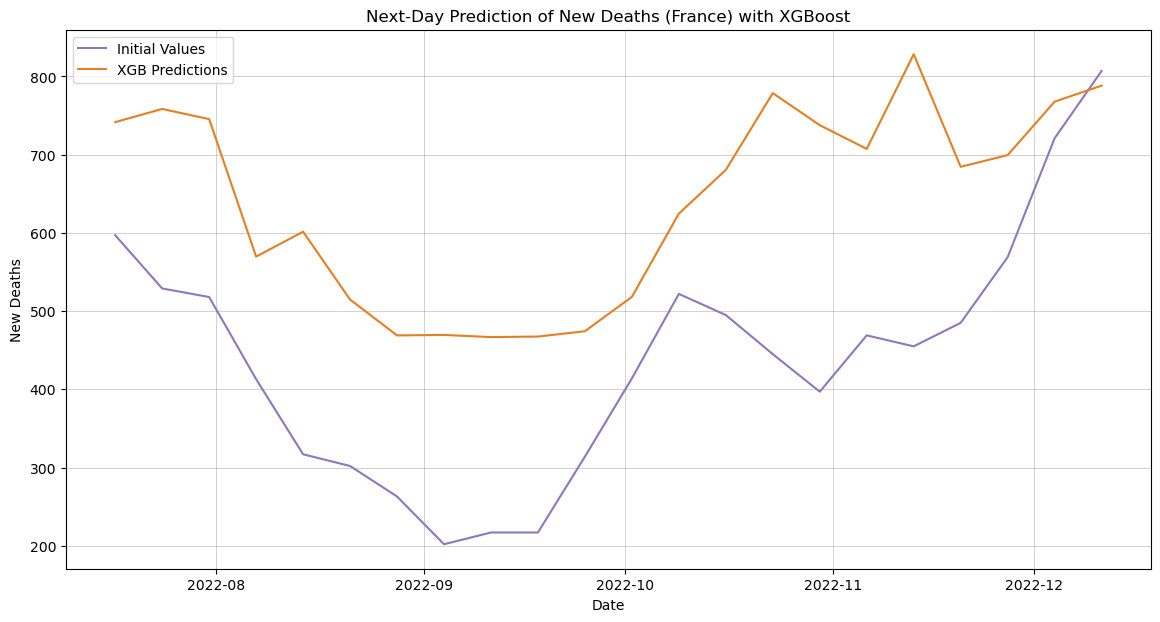

In [192]:
# Séparation train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Modèle XGBoost
xgb_france_model = xgb.XGBRegressor()

# Cross-validation
xgb_scores = cross_val_score(
    xgb_france_model, 
    X, y['target_t_plus'], 
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
)
print("XGBoost - RMSE pour chaque split :", -xgb_scores)
print("XGBoost - RMSE moyen :", -xgb_scores.mean())

# Fit sur train et prédiction sur test
xgb_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = xgb_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"XGBoost France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

# Plot
plt.figure(figsize=(14,7), facecolor="white")
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Initial Values', color='#8D77BD')
plt.plot(y_test['date_t_plus'], y_pred_france, label='XGB Predictions', color="#E67E22")
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.set_title('Next-Day Prediction of New Deaths (France) with XGBoost')
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.legend()
plt.show()


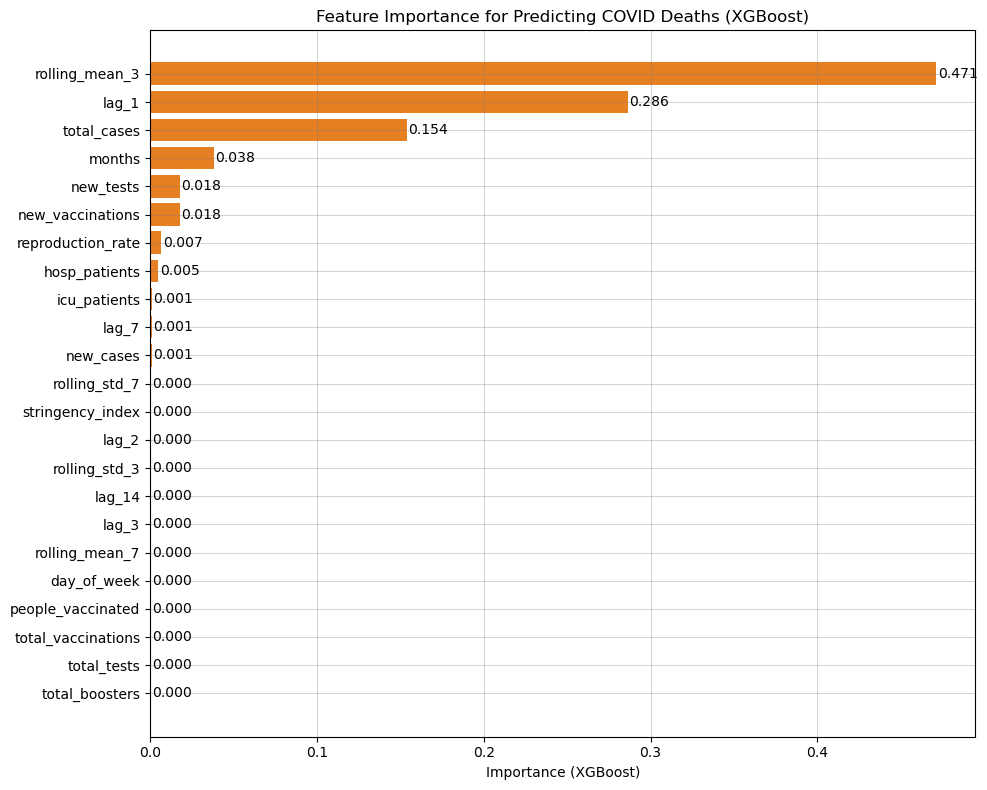

In [189]:
# Extraire les importances des features du XGBoost
feature_importances = xgb_france_model.feature_importances_

coef_df = pd.DataFrame({
    "Feature": X.columns,  # ou X_lags si tu utilises des lagged features
    "Importance": feature_importances
})

# Trier par importance
coef_df_sorted = coef_df.sort_values(by="Importance", ascending=True)

# Figure
fig, ax = plt.subplots(figsize=(10, 8))

# Bar plot horizontal
ax.barh(coef_df_sorted["Feature"], coef_df_sorted["Importance"], color="#E67E22")
ax.set_xlabel("Importance (XGBoost)")
ax.set_title("Feature Importance for Predicting COVID Deaths (XGBoost)")
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)

# Ajouter valeurs sur les barres
for i, (imp, feat) in enumerate(zip(coef_df_sorted["Importance"], coef_df_sorted["Feature"])):
    ax.text(imp + 0.001, i, f"{imp:.3f}", va="center")

plt.tight_layout()
plt.show()


## HPO (hyperparameters optimization) with Optuna

### RF

In [190]:
import optuna

### HPO (hyperparameters optimization) with Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create the model with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Cross-validation
    scores = cross_val_score(model, X, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
    
    # Return the mean RMSE across the folds
    ponderation = np.array([0.2,0.3,0.5])
    return -scores.dot(ponderation) #dot : produit entre vecteurs
# ponderation des features

study = optuna.create_study()
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(trial.params)


[I 2025-09-30 23:56:11,515] A new study created in memory with name: no-name-de838b14-59e9-4be5-9e3a-f8924606c31d
[I 2025-09-30 23:56:13,703] Trial 0 finished with value: 560.9741768374097 and parameters: {'n_estimators': 575, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 13}. Best is trial 0 with value: 560.9741768374097.
[I 2025-09-30 23:56:16,938] Trial 1 finished with value: 505.8065651217436 and parameters: {'n_estimators': 744, 'max_depth': 37, 'min_samples_split': 16, 'min_samples_leaf': 15}. Best is trial 1 with value: 505.8065651217436.
[I 2025-09-30 23:56:19,171] Trial 2 finished with value: 483.07178980261926 and parameters: {'n_estimators': 512, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 9}. Best is trial 2 with value: 483.07178980261926.
[I 2025-09-30 23:56:20,638] Trial 3 finished with value: 563.1702422343778 and parameters: {'n_estimators': 450, 'max_depth': 28, 'min_samples_split': 12, 'min_samples_leaf': 18}. Best is trial 2 with valu

Best trial:
  Value: 252.3460856173241
{'n_estimators': 305, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [199]:
tscv = TimeSeriesSplit(n_splits=3)

param = {'n_estimators': 305, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}

rf_france_model = RandomForestRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    min_samples_split=param['min_samples_split'],
    min_samples_leaf=param['min_samples_leaf'],
    random_state=42
)
rf_scores = cross_val_score(rf_france_model, X, y['target_t_plus'], cv=tscv, scoring='neg_root_mean_squared_error')
print("Random Forest - RMSE pour chaque split :", -rf_scores)
print("Random Forest - RMSE moyen :", -rf_scores.mean())

rf_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = rf_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"Random Forest France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

Random Forest - RMSE pour chaque split : [339.08334222 448.7696457   99.79704693]
Random Forest - RMSE moyen : 295.8833449494378
Random Forest France -> RMSE: 109.9048, R2: 0.4914


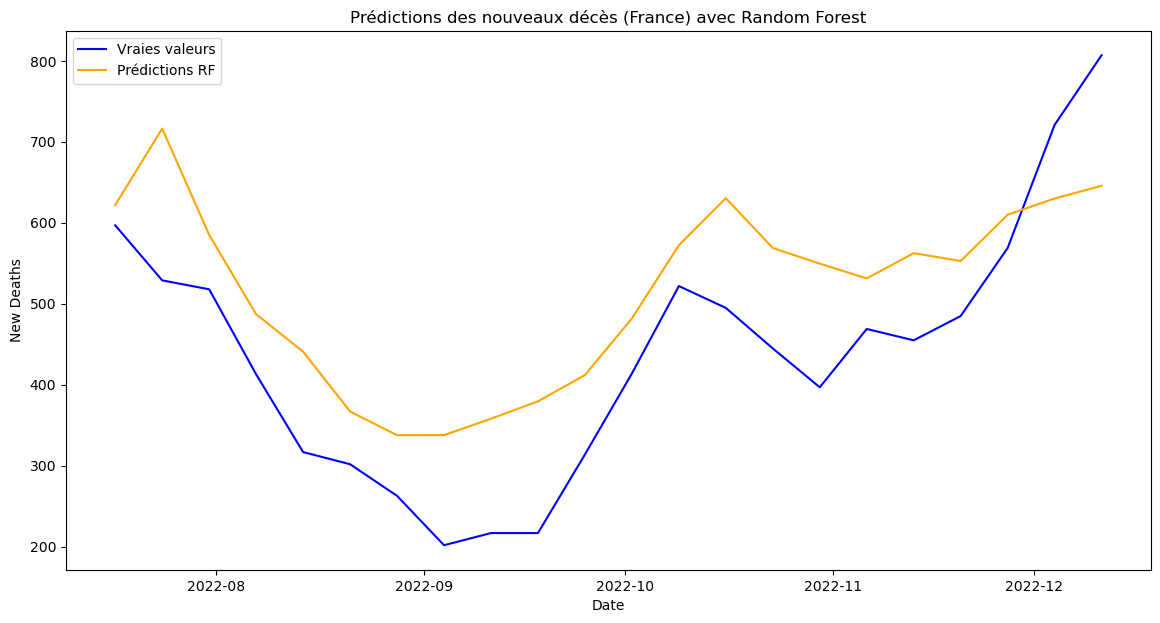

In [200]:
# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Vraies valeurs', color='blue')
plt.plot(y_test['date_t_plus'], y_pred_france, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths')
plt.title('Prédictions des nouveaux décès (France) avec Random Forest')
plt.legend()
plt.show()

### XGBoost

In [203]:
import optuna

tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    # Hyperparameters to tune (valid for XGBRegressor)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )

    # Cross-validation
    scores = cross_val_score(
        model,
        X,
        y['target_t_plus'],
        cv=tscv,
        scoring='neg_root_mean_squared_error'
    )
    ponderation = np.array([0.2,0.3,0.5])
    return -scores.dot(ponderation) #dot : produit entre vecteurs
    #return -scores.mean()

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
print(trial.params)


[I 2025-10-01 00:10:54,461] A new study created in memory with name: no-name-f26a4fe7-412f-49a8-a1f3-e748585d389d
[I 2025-10-01 00:10:57,069] Trial 0 finished with value: 394.62847530601283 and parameters: {'n_estimators': 295, 'max_depth': 3, 'learning_rate': 0.11756224968491913, 'subsample': 0.9084820090729058, 'colsample_bytree': 0.7920403008253822, 'gamma': 4.256700060591291}. Best is trial 0 with value: 394.62847530601283.
[I 2025-10-01 00:11:01,814] Trial 1 finished with value: 423.13400173543835 and parameters: {'n_estimators': 506, 'max_depth': 5, 'learning_rate': 0.16954745352255482, 'subsample': 0.7451407020807598, 'colsample_bytree': 0.8007275515312491, 'gamma': 0.7597923323855427}. Best is trial 0 with value: 394.62847530601283.
[I 2025-10-01 00:11:03,085] Trial 2 finished with value: 493.1971804244494 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.010781251496460023, 'subsample': 0.7237947999388665, 'colsample_bytree': 0.5431859630614684, 'gamma':

Best trial:
  Value: 288.90772396297666
  Params: 
{'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.13662250155407524, 'subsample': 0.52936190243025, 'colsample_bytree': 0.5187429609948483, 'gamma': 1.197743897232566}


In [209]:
param = {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.13662250155407524, 'subsample': 0.52936190243025, 'colsample_bytree': 0.5187429609948483, 'gamma': 1.197743897232566}

xgb_france_model = xgb.XGBRegressor(
    n_estimators=param['n_estimators'],
    max_depth=param['max_depth'],
    learning_rate=param['learning_rate'],
    subsample=param['subsample'],
    colsample_bytree=param['colsample_bytree'],
    gamma=param['gamma'],
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1
)

xgb_france_model.fit(X_train, y_train['target_t_plus'])
y_pred_france = xgb_france_model.predict(X_test)

# Évaluation
mse_france = root_mean_squared_error(y_test['target_t_plus'], y_pred_france)
r2_france = r2_score(y_test['target_t_plus'], y_pred_france)
print(f"XGBoost France -> RMSE: {mse_france:.4f}, R2: {r2_france:.4f}")

XGBoost France -> RMSE: 167.6571, R2: -0.1834


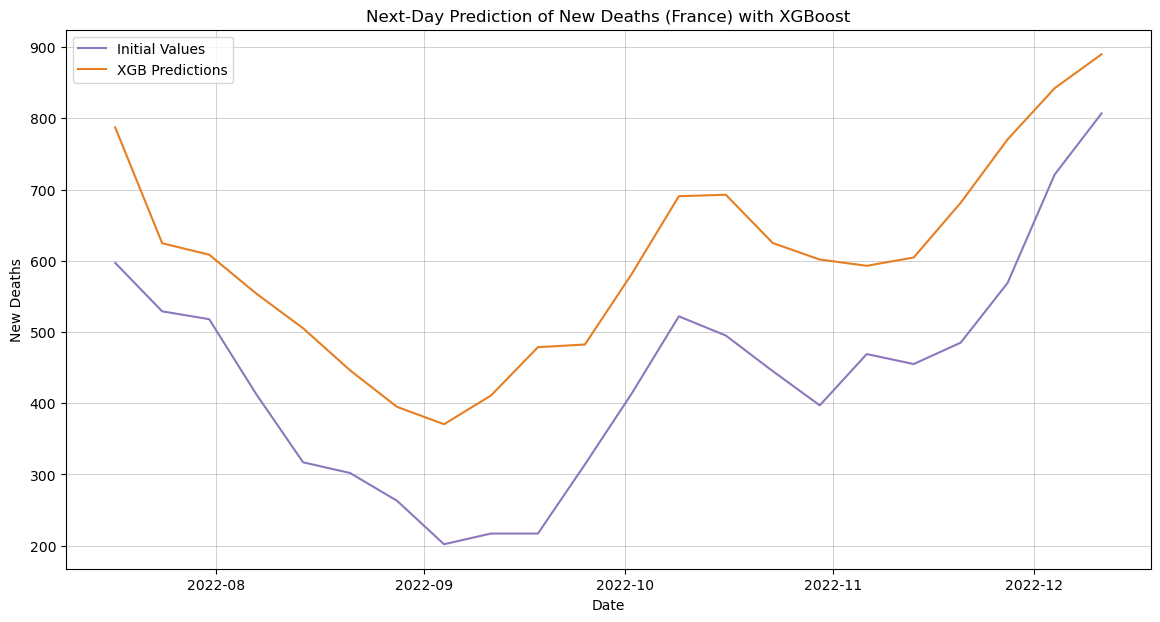

In [210]:
# plot des résultats
plt.figure(figsize=(14,7), facecolor="white")
plt.plot(y_test['date_t_plus'], y_test['target_t_plus'], label='Initial Values', color='#8D77BD')
plt.plot(y_test['date_t_plus'], y_pred_france, label='XGB Predictions', color="#E67E22")
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')
ax.set_title('Next-Day Prediction of New Deaths (France) with XGBoost')
ax.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
ax.legend()
plt.show()

## Generalisation

In [82]:
df_europe.country.unique()

array(['Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

In [211]:
df_italy = df_europe[df_europe['country'] == 'Italy']

In [ ]:
df_italy_augmented = feature_engineering(df_italy)

# Supprimer les lignes qui ont des NaN
df_model = df_italy_augmented.dropna()

#X = df_model.drop(columns=["country", "date", "date_t_plus7","target_t_plus7", "new_deaths"])
y_italy = df_model[["date_t_plus7", "target_t_plus7"]]
X_italy = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

89.03646017412028


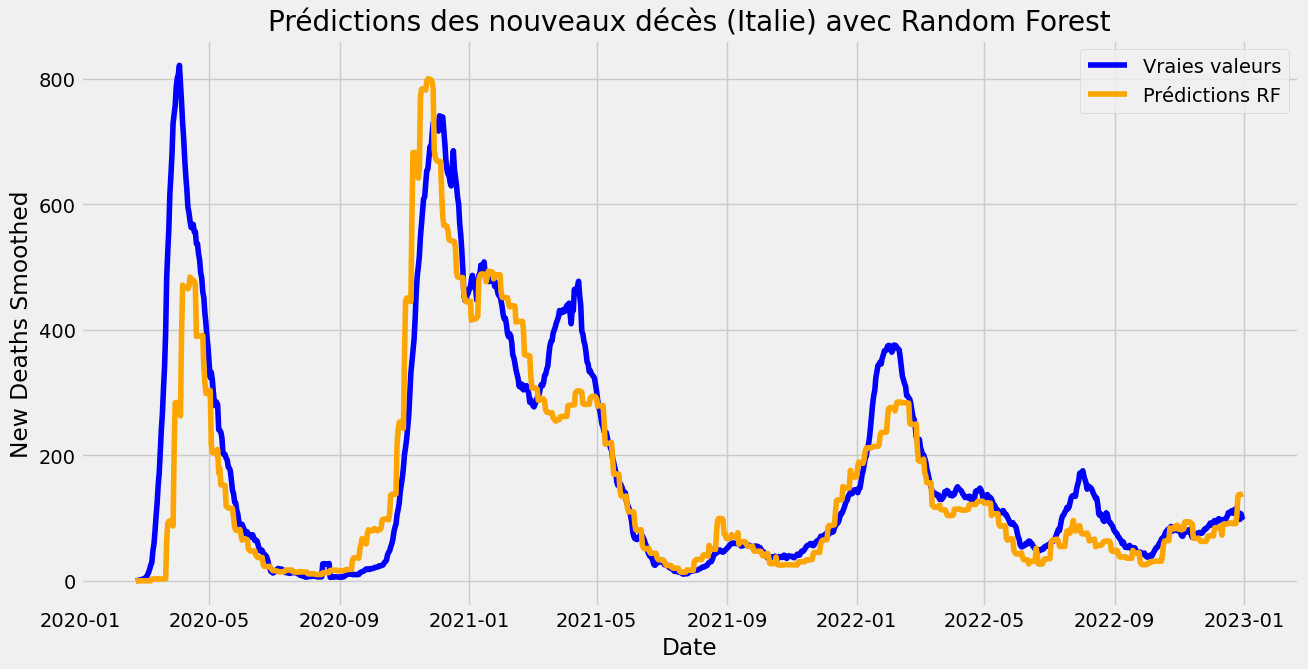

In [89]:
y_pred_italy = rf_france_model.predict(X)

rmse_italy = root_mean_squared_error(y_italy['target_t_plus7'], y_pred_italy)
print(rmse_italy)

# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_italy['date_t_plus7'], y_italy['target_t_plus7'], label='Vraies valeurs', color='blue')
plt.plot(y_italy['date_t_plus7'], y_pred_italy, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths Smoothed')
plt.title('Prédictions des nouveaux décès (Italie) avec Random Forest')
plt.legend()
plt.show()


### Allemagne

In [64]:
df_europe.country.unique()

array(['Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Bulgaria', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Moldova',
       'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Ukraine', 'United Kingdom'], dtype=object)

In [65]:
df_germany = df_europe[df_europe['country'] == 'Germany']

In [93]:
df_germany_augmented = feature_engineering(df_germany)

# Supprimer les lignes qui ont des NaN
df_model = df_germany_augmented.dropna()

#X = df_model.drop(columns=["country", "date", "date_t_plus7","target_t_plus7", "new_deaths"])
y_germany = df_model[["date_t_plus7", "target_t_plus7"]]
X_germany = X[["lag_1", "lag_2", "lag_3", "lag_7", "lag_14", "rolling_mean_3", "rolling_std_3", "rolling_mean_7", "rolling_std_7", "day_of_week", "months"]]

In [94]:
y_germany_pred = rf_france_model.predict(X_germany)
rmse_germany = root_mean_squared_error(y_germany['target_t_plus7'], y_germany_pred)
print(rmse_germany)

131.06758548522953


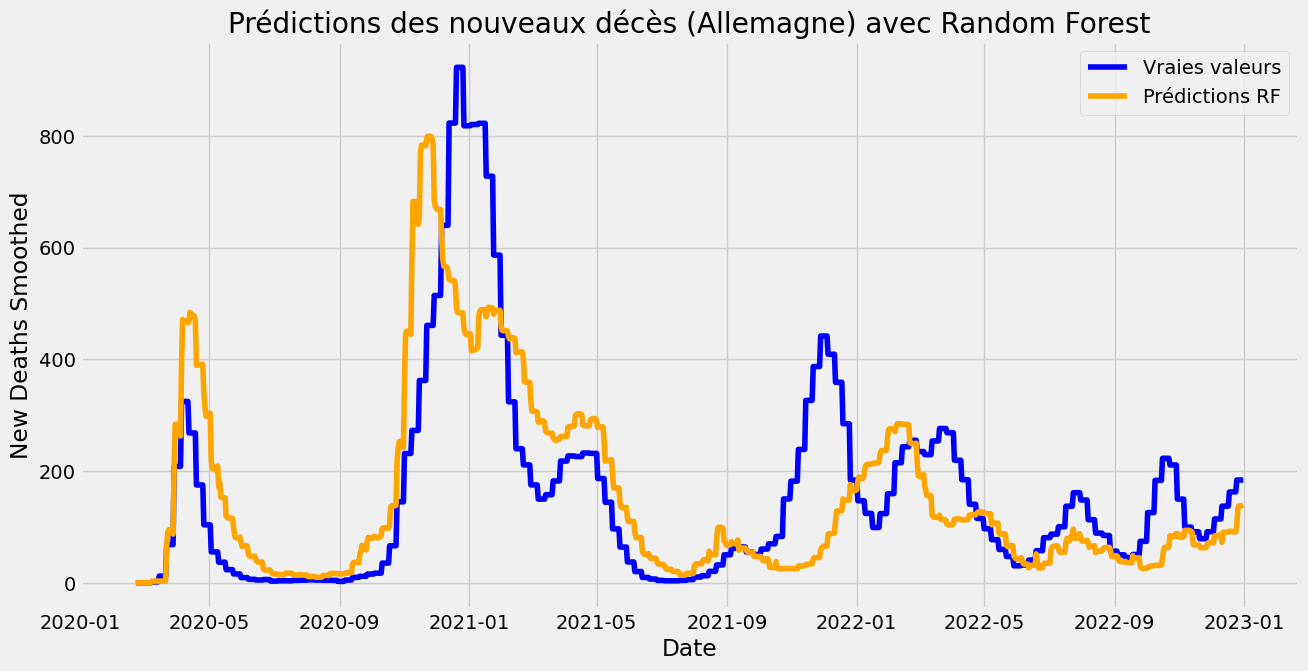

In [95]:
# plot des résultats
plt.figure(figsize=(14,7))
plt.plot(y_germany['date_t_plus7'], y_germany['target_t_plus7'], label='Vraies valeurs', color='blue')
plt.plot(y_germany['date_t_plus7'], y_germany_pred, label='Prédictions RF', color='orange')
plt.xlabel('Date')
plt.ylabel('New Deaths Smoothed')
plt.title('Prédictions des nouveaux décès (Allemagne) avec Random Forest')
plt.legend()
plt.show()


## SARIMA car new_death_smoothed capture la saisonnalité

                                      SARIMAX Results                                      
Dep. Variable:                      target_t_plus7   No. Observations:                 1044
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -4127.362
Date:                             Sun, 28 Sep 2025   AIC                           8268.723
Time:                                     23:30:49   BIC                           8303.325
Sample:                                          0   HQIC                          8281.852
                                            - 1044                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009    747.622   1.22e-06      1.000   -1465.311    1465.312
ar.L2          0.0009    86

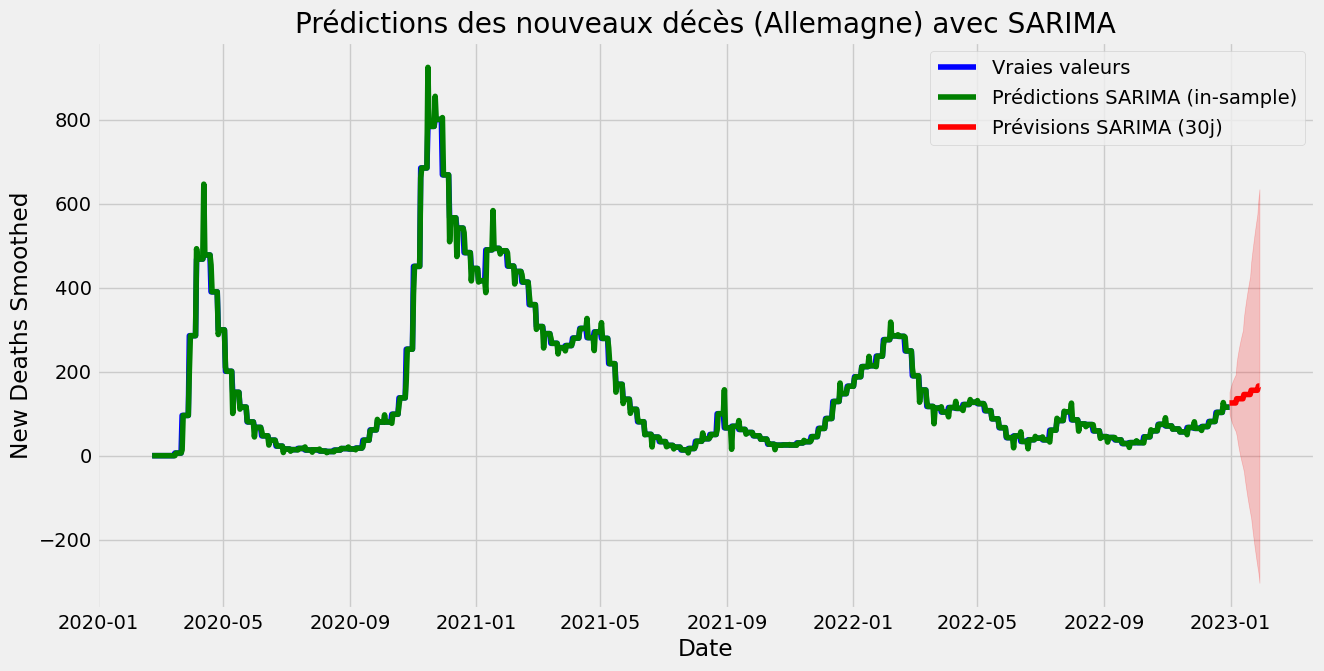

In [99]:
dates = df_model["date_t_plus7"]
y = df_model["target_t_plus7"]

# --- Entraîner le SARIMA ---
model_sarima = SARIMAX(y, order=(2,1,2), seasonal_order=(1,1,1,7))
result = model_sarima.fit()

print(result.summary())

# --- Faire une prédiction sur toute la période disponible ---
y_pred = result.fittedvalues  # valeurs ajustées sur l'échantillon

# --- Faire une prévision sur 30 pas en avant ---
forecast = result.get_forecast(steps=30)
forecast_ci = forecast.conf_int()

# --- Plot ---
plt.figure(figsize=(14,7))
plt.plot(dates, y, label="Vraies valeurs", color="blue")
plt.plot(dates, y_pred, label="Prédictions SARIMA (in-sample)", color="green")

# Ajouter les prévisions futures
future_dates = pd.date_range(start=dates.iloc[-1], periods=30, freq="D")
plt.plot(future_dates, forecast.predicted_mean, label="Prévisions SARIMA (30j)", color="red")
plt.fill_between(future_dates,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color="red", alpha=0.2)

plt.xlabel("Date")
plt.ylabel("New Deaths Smoothed")
plt.title("Prédictions des nouveaux décès (Allemagne) avec SARIMA")
plt.legend()
plt.show()


## Cross Val

### Régression linéaire

In [ ]:
# Exemple avec LinearRegression
X = df_europe[features_corrected]
y = df_europe["new_deaths_smoothed"]

tscv = TimeSeriesSplit(n_splits=5)
model = LinearRegression()

scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("MSE pour chaque split :", -scores)
print("MSE moyen :", -scores.mean())

MSE pour chaque split : [25186.37601253  7202.4314685   1401.98446903  3291.13244369
 14194.15465737]
MSE moyen : 10255.215810223108


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("Random Forest - MSE pour chaque split :", -rf_scores)
print("Random Forest - MSE moyen :", -rf_scores.mean())

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_scores = cross_val_score(xgb_model, X, y, cv=tscv, scoring='neg_mean_squared_error')
print("XGBoost - MSE pour chaque split :", -xgb_scores)
print("XGBoost - MSE moyen :", -xgb_scores.mean())

Random Forest - MSE pour chaque split : [12261.72446695  2860.20986125   331.87921568  2319.64127985
 15763.22331537]
Random Forest - MSE moyen : 6707.335627819268
XGBoost - MSE pour chaque split : [12140.87493673  3192.85042964   172.52563013  2977.89683536
 15638.53422326]
XGBoost - MSE moyen : 6824.53641102158


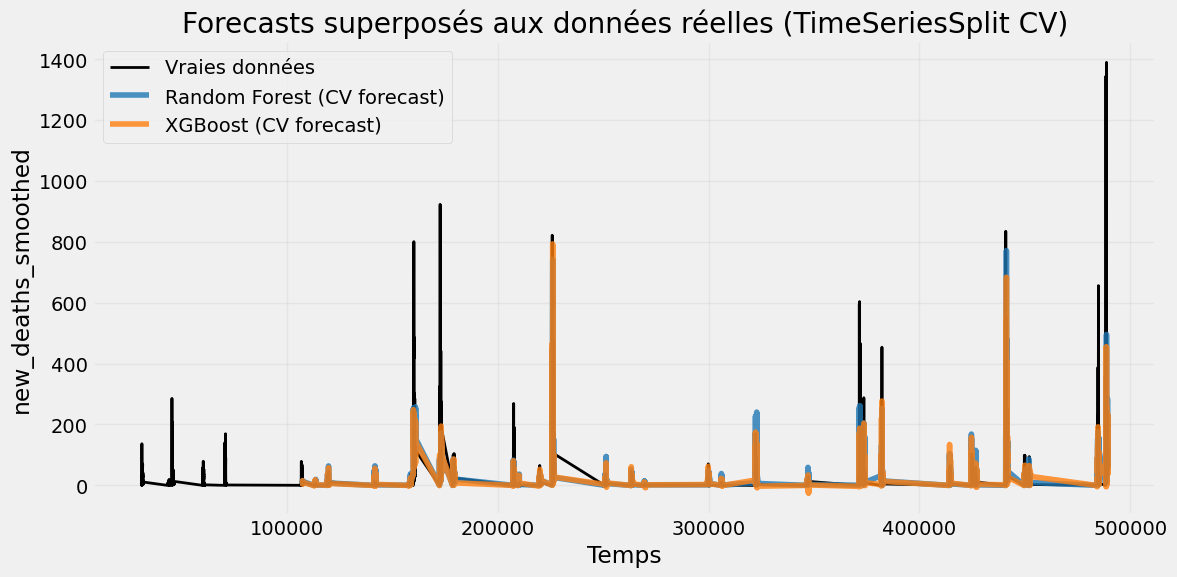

In [ ]:
# --- Modèles à comparer ---
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# --- Construction des prédictions CV ---
cv_preds = {name: np.full_like(y, np.nan, dtype=float) for name in models}  # NaN = pas de prédiction encore

for model_name, model in models.items():
    for train_idx, test_idx in tscv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        cv_preds[model_name][test_idx] = y_pred
        print()


NameError: name 'cv_preds' is not defined

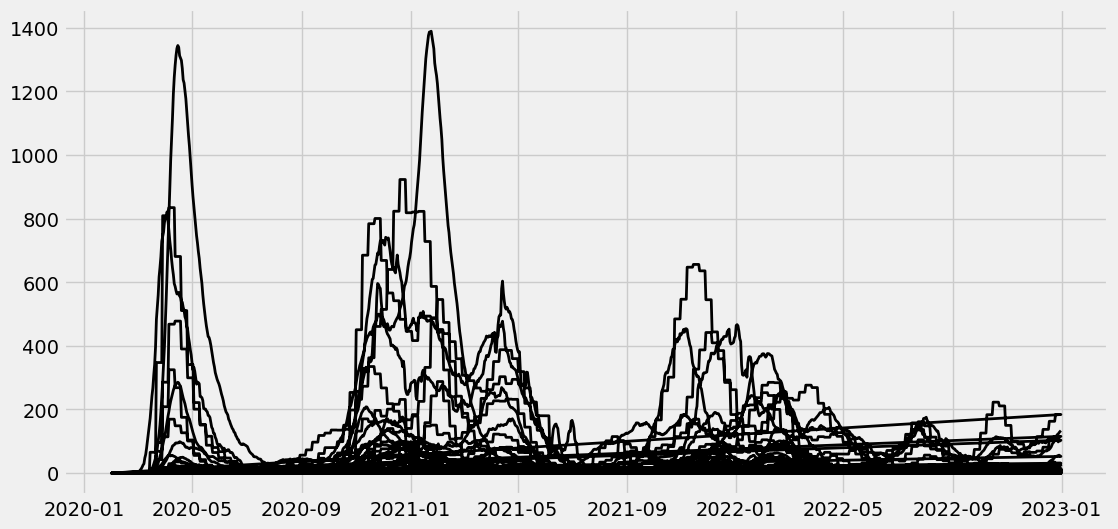

In [ ]:
# --- Plot global comme "plot_series" ---
plt.figure(figsize=(12,6))
time_index = df_europe["date"] 

# données réelles
plt.plot(time_index, y, color="black", linewidth=2, label="Vraies données")

# prédictions
colors = ["tab:blue", "tab:orange"]
for (model_name, preds), color in zip(cv_preds.items(), colors):
    plt.plot(time_index, preds, color=color, alpha=0.8, label=f"{model_name} (CV forecast)")

plt.title("Forecasts superposés aux données réelles (TimeSeriesSplit CV)")
plt.xlabel("Temps")
plt.ylabel("new_deaths_smoothed")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

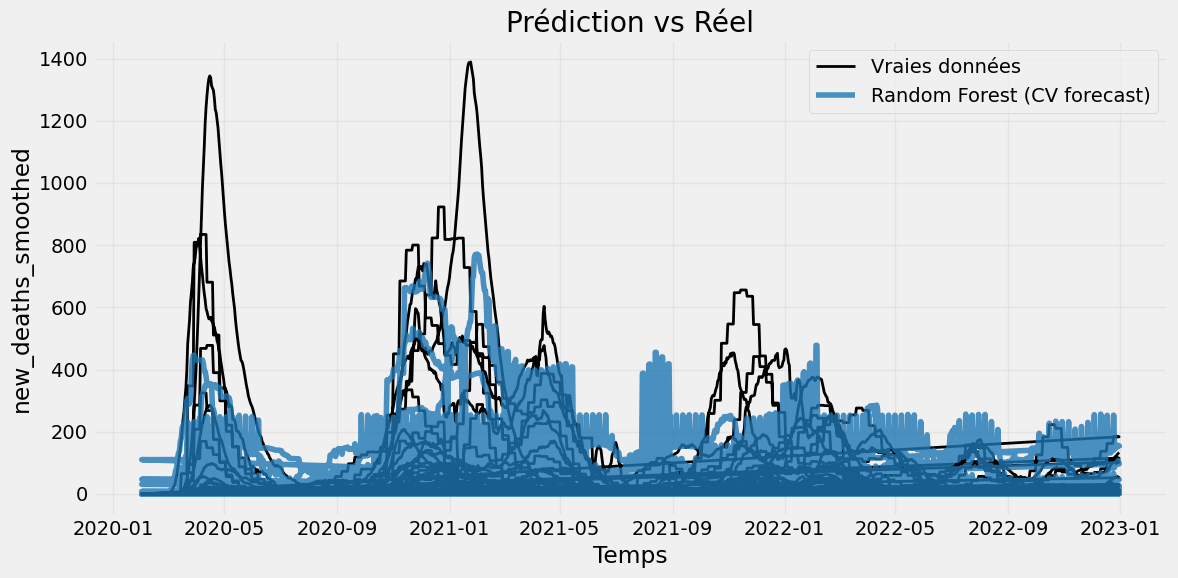

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(time_index, y, color="black", linewidth=2, label="Vraies données")
plt.plot(time_index, cv_preds["Random Forest"], color="tab:blue", alpha=0.8, label="Random Forest (CV forecast)")
# ou pour XGBoost : plt.plot(time_index, cv_preds["XGBoost"], ...)
plt.title("Prédiction vs Réel")
plt.xlabel("Temps")
plt.ylabel("new_deaths_smoothed")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Génération des prédictions pour la visualisation...
Prédictions terminées.


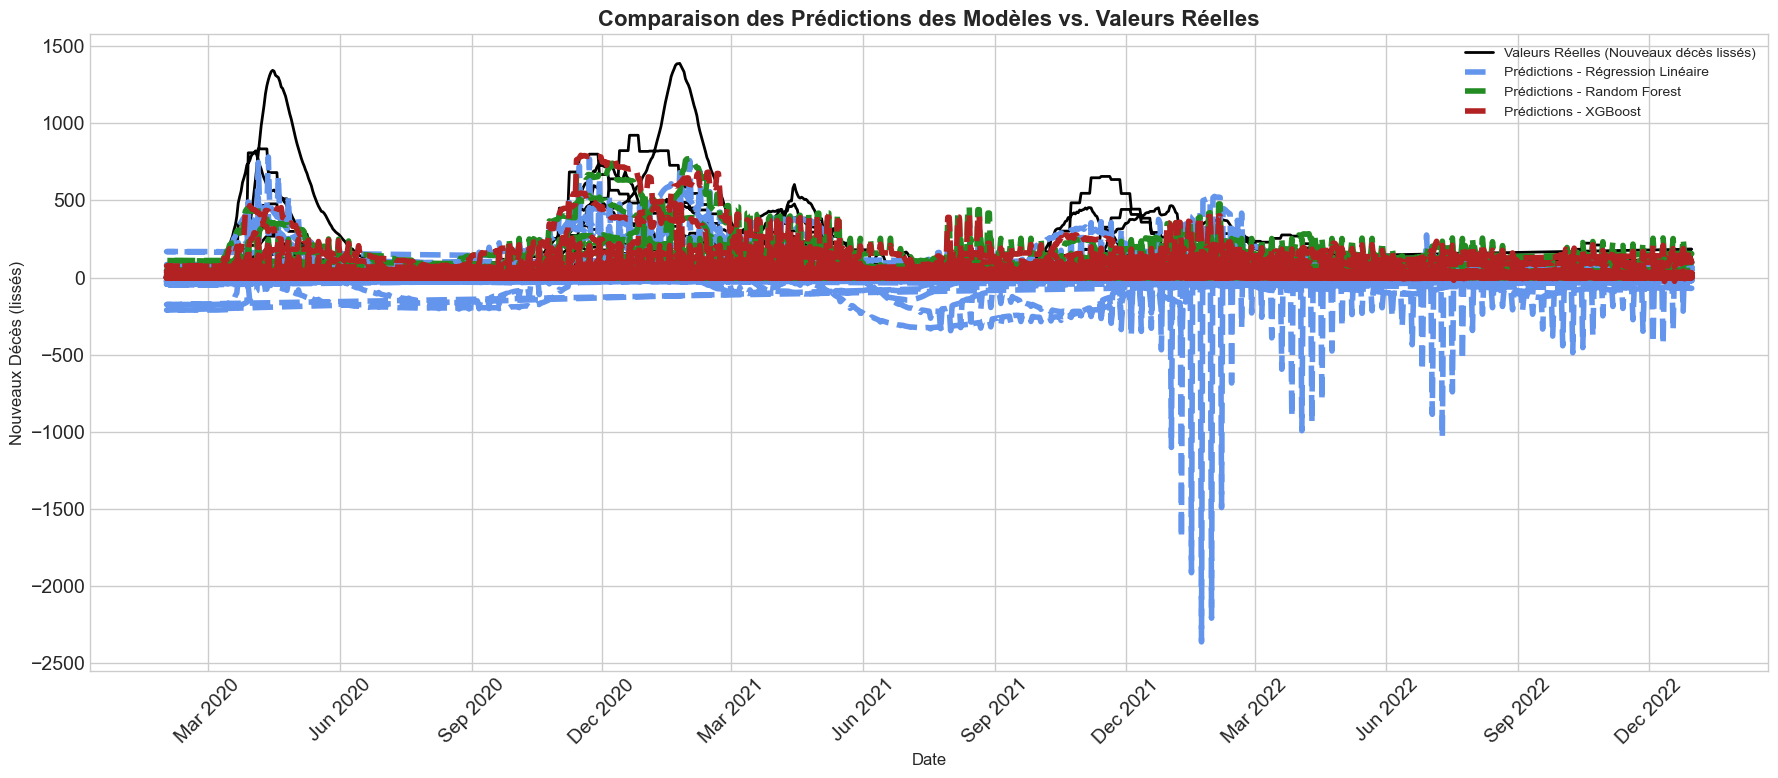

In [ ]:
# Assurez-vous que votre colonne de date est au format datetime
#df_europe['date'] = pd.to_datetime(df_europe['date'])

# --- Étape 1 (Corrigée): Générer les prédictions manuellement ---

# On crée une fonction pour éviter de répéter le code pour chaque modèle
def manual_cross_val_predict(model, X, y, cv_splitter):
    """
    Fonction qui réplique cross_val_predict pour les séries temporelles.
    Elle retourne une série pandas avec des NaNs pour les points non prédits.
    """
    predictions = pd.Series(index=y.index, dtype=float) # Séries vides avec le bon index
    
    # Boucle sur chaque split (train/test) défini par TimeSeriesSplit
    for train_index, test_index in cv_splitter.split(X):
        # 1. Séparer les données d'entraînement et de test
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = y.iloc[train_index]
        
        # 2. Entraîner le modèle
        model.fit(X_train, y_train)
        
        # 3. Faire les prédictions
        preds_fold = model.predict(X_test)
        
        # 4. Stocker les prédictions à la bonne place
        predictions.iloc[test_index] = preds_fold
        
    return predictions

# Générer les prédictions pour chaque modèle avec notre fonction
print("Génération des prédictions pour la visualisation...")
lr_predictions = manual_cross_val_predict(model, X, y, tscv)
rf_predictions = manual_cross_val_predict(rf_model, X, y, tscv)
xgb_predictions = manual_cross_val_predict(xgb_model, X, y, tscv)
print("Prédictions terminées.")


# --- Étape 2 et 3: Créer le graphique de comparaison (CE BLOC RESTE INCHANGÉ) ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# Tracer la courbe des vraies valeurs
ax.plot(df_europe['date'], y, label='Valeurs Réelles (Nouveaux décès lissés)', color='black', linewidth=2)

# Tracer les prédictions de chaque modèle
# Matplotlib ignore automatiquement les valeurs NaN au début des séries
ax.plot(df_europe['date'], lr_predictions, label='Prédictions - Régression Linéaire', linestyle='--', color='cornflowerblue')
ax.plot(df_europe['date'], rf_predictions, label='Prédictions - Random Forest', linestyle='--', color='forestgreen')
ax.plot(df_europe['date'], xgb_predictions, label='Prédictions - XGBoost', linestyle='--', color='firebrick')

# Mise en forme du graphique
ax.set_title('Comparaison des Prédictions des Modèles vs. Valeurs Réelles', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Nouveaux Décès (lissés)', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Pipeline Kaggle

In [ ]:
# # Liste des pays européens
# european_countries = [
#     "France", "Germany", "Italy", "Spain", "Portugal", "Belgium", "Netherlands",
#     "Luxembourg", "Switzerland", "Austria", "Poland", "Czech Republic",
#     "Slovakia", "Hungary", "Slovenia", "Croatia", "Bosnia and Herzegovina",
#     "Serbia", "Montenegro", "Kosovo", "Albania", "North Macedonia", "Greece",
#     "Bulgaria", "Romania", "Moldova", "Ukraine", "Belarus", "Lithuania",
#     "Latvia", "Estonia", "Norway", "Sweden", "Finland", "Denmark", "Iceland",
#     "Ireland", "United Kingdom", "Malta", "Cyprus"
# ]

# # =========================================================
# # 1. Charger, filtrer Europe et inspecter
# # =========================================================
# def load_and_filter(csv_path, european_countries = european_countries, date_col="date", country_col="country"):
#     """
#     Charge le CSV et filtre uniquement sur la liste de pays européens.
#     """

#     df = pd.read_csv(csv_path)

#     # Filtrer uniquement les pays européens
#     df = df[df[country_col].isin(european_countries)].copy()

#     # Vérifier contenu
#     print("Pays européens présents dans le dataset :", df[country_col].nunique())
#     print("Exemple de pays :", df[country_col].unique()[:10])
#     print("Colonnes disponibles :", df.columns.tolist())

#     # Conversion date
#     df[date_col] = pd.to_datetime(df[date_col])
#     df = df.sort_values([country_col, date_col])

#     return df

In [ ]:
# =========================================================
# 2. Prétraitement (NaN, négatifs, harmonisation)
# =========================================================
def preprocess(df):
    # Remplissage NaN par ffill (propagation) ou 0
    df = df.groupby("country").ffill().fillna(0)

    # Supprimer valeurs négatives
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df[col] = df[col].clip(lower=0) # Remplace négatifs par 0
    return df

In [ ]:
# =========================================================
# 3. Construction séries temporelles par pays
# =========================================================
def build_timeseries(df, target="new_cases"):
    df = df.copy()

    # Cas journaliers smoothed si dispo, évite le bruit dans les données
    if "new_cases_smoothed" in df.columns:
        df["y"] = df["new_cases_smoothed"] 
    else:
        df["y"] = df[target]

    # Rolling moyenne 7j
    df["y_ma7"] = df.groupby("country")["y"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

    # Features temporelles, lags comme features
    df["day_of_week"] = df["date"].dt.dayofweek # 0=Monday, 6=Sunday, certains pays testent des patterns hebdo
    df["lag1"] = df.groupby("country")["y"].shift(1).fillna(0)
    df["lag7"] = df.groupby("country")["y"].shift(7).fillna(0) # Lag 7 jours : cases il y a une semaine

    # Features santé si dispo
    for col in ["hosp_patients", "icu_patients", "total_vaccinations", "new_tests"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    return df

In [ ]:

# =========================================================
# 4. Train/Test split temporel
# =========================================================
def train_test_split_time(sub, features, target="y", test_size=30, shuffle=False):
    X = sub[features].values
    y = sub[target].values

    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]
    return X_train, X_test, y_train, y_test

In [ ]:
# =========================================================
# 5. Modèles ML (Linear, SVR)
# =========================================================
def train_models(X_train, X_test, y_train, y_test):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_s = scaler_X.fit_transform(X_train)
    X_test_s = scaler_X.transform(X_test)

    y_train_s = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

    results = {}

    # Linear Regression
    lin = LinearRegression()
    lin.fit(X_train_s, y_train_s)
    lin_pred = scaler_y.inverse_transform(lin.predict(X_test_s).reshape(-1,1)).ravel()
    results["Linear"] = lin_pred

    # SVR
    svr = SVR(kernel="rbf", C=10, gamma=0.1, epsilon=0.1)
    svr.fit(X_train_s, y_train_s)
    svr_pred = scaler_y.inverse_transform(svr.predict(X_test_s).reshape(-1,1)).ravel()
    results["SVR"] = svr_pred

    return results

In [ ]:
# =========================================================
# 6. ARIMA baseline : auto-régression intégrée de moyenne mobile
# =========================================================
def train_arima(sub, target="y", test_size=30, order=(5,1,0)):
    train, test = sub[target][:-test_size], sub[target][-test_size:]
    model = sm.tsa.ARIMA(train, order=order)
    model_fit = model.fit()
    arima_pred = model_fit.forecast(steps=test_size)
    return test.values, arima_pred


In [ ]:
# =========================================================
# 7. Évaluation
# =========================================================
def evaluate(y_test, preds):
    for name, pred in preds.items():
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

In [ ]:
# =========================================================
# 8. Visualisation
# =========================================================
def plot_results(dates, y_test, preds):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_test, label="Réel", linewidth=2)
    for name, pred in preds.items():
        plt.plot(dates, pred, label=name)
    plt.title("Prédictions vs Réel")
    plt.xlabel("Date")
    plt.ylabel("Nouveaux cas (smoothed)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


=== Résultats France ===
Linear -> MAE: 99.75, RMSE: 185.66
SVR -> MAE: 2409.69, RMSE: 3029.31
ARIMA -> MAE: 0.00, RMSE: 0.00


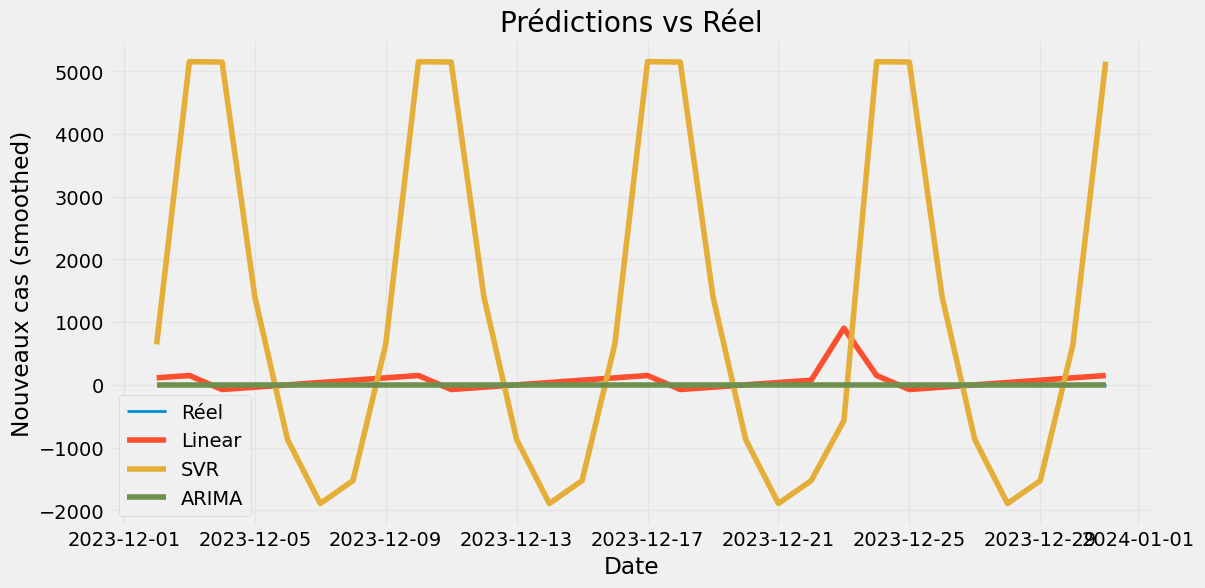


=== Résultats Germany ===
Linear -> MAE: 20.16, RMSE: 34.00
SVR -> MAE: 2201.88, RMSE: 2881.28
ARIMA -> MAE: 0.00, RMSE: 0.00


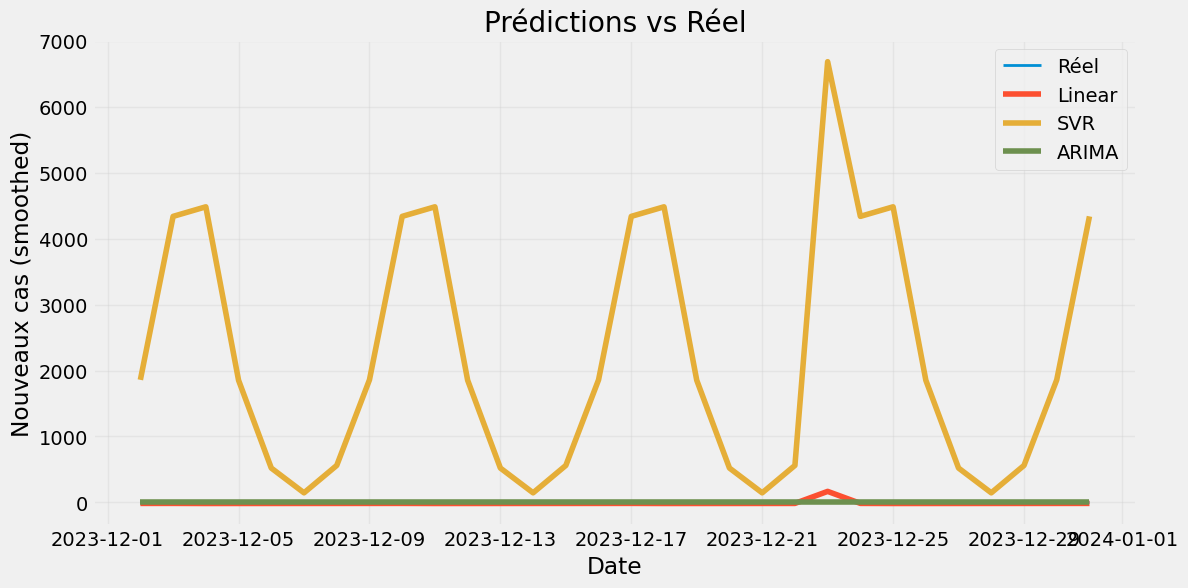


=== Résultats Italy ===
Linear -> MAE: 407.24, RMSE: 752.25
SVR -> MAE: 1808.65, RMSE: 1947.23
ARIMA -> MAE: 1568.24, RMSE: 2210.36


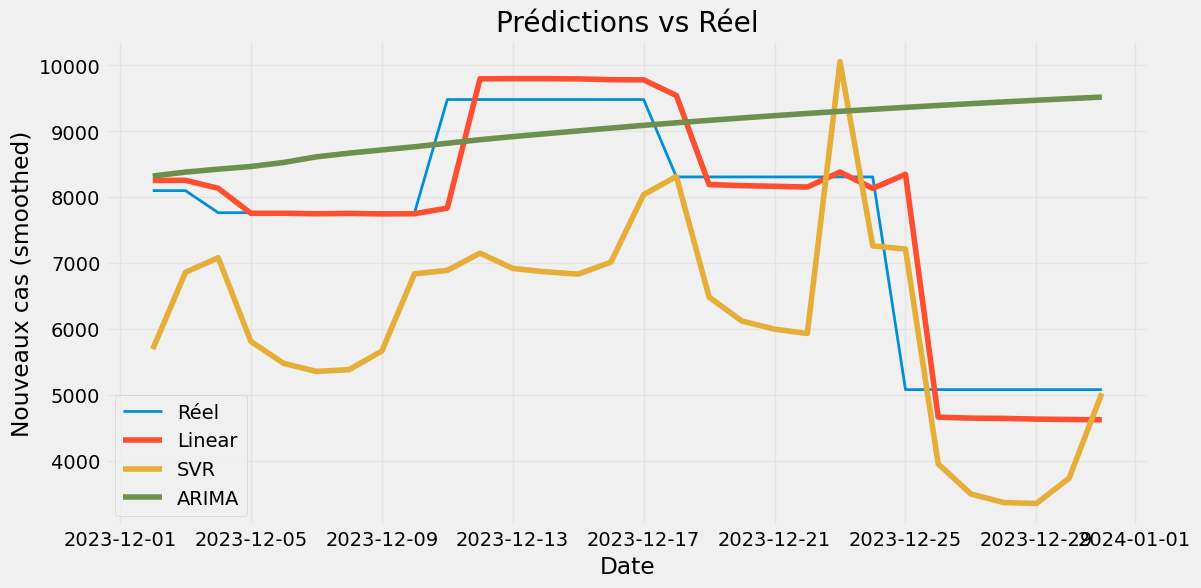


=== Résultats Spain ===
Linear -> MAE: 127.98, RMSE: 162.25
SVR -> MAE: 880.99, RMSE: 1486.14
ARIMA -> MAE: 0.00, RMSE: 0.00


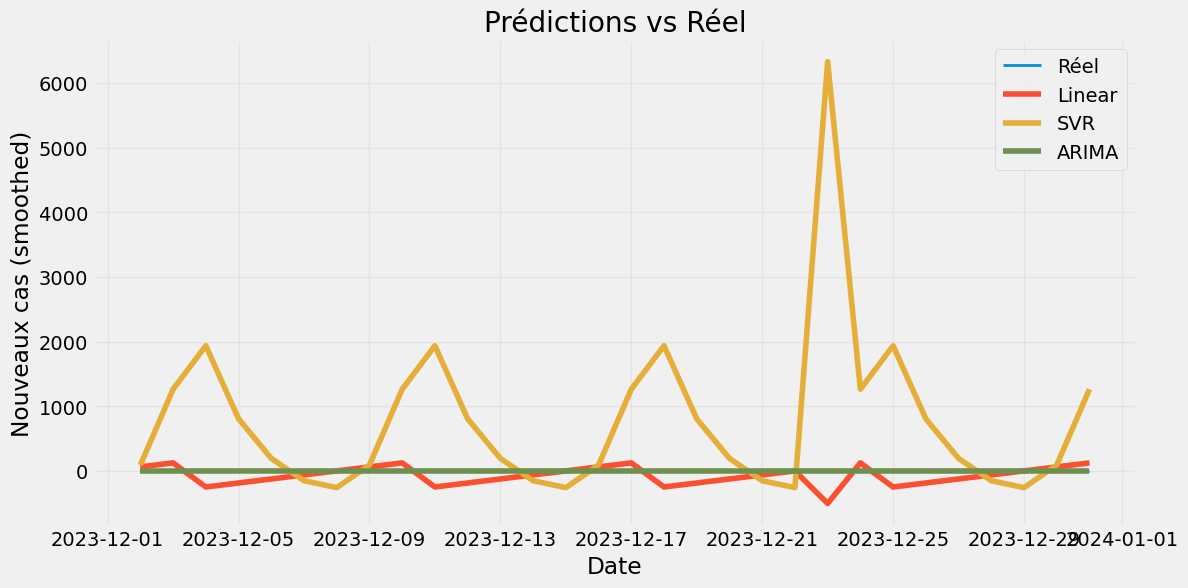


=== Résultats Portugal ===
Linear -> MAE: 20.67, RMSE: 25.65
SVR -> MAE: 302.62, RMSE: 389.02
ARIMA -> MAE: 35.33, RMSE: 40.82


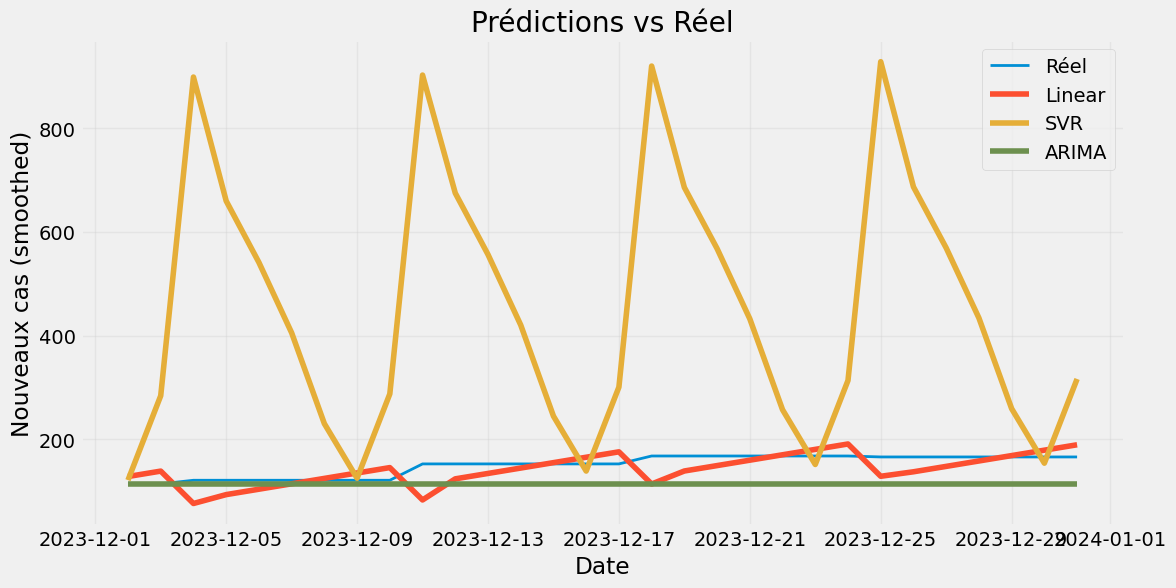


=== Résultats Belgium ===
Linear -> MAE: 34.41, RMSE: 48.39
SVR -> MAE: 396.64, RMSE: 408.17
ARIMA -> MAE: 193.58, RMSE: 208.02


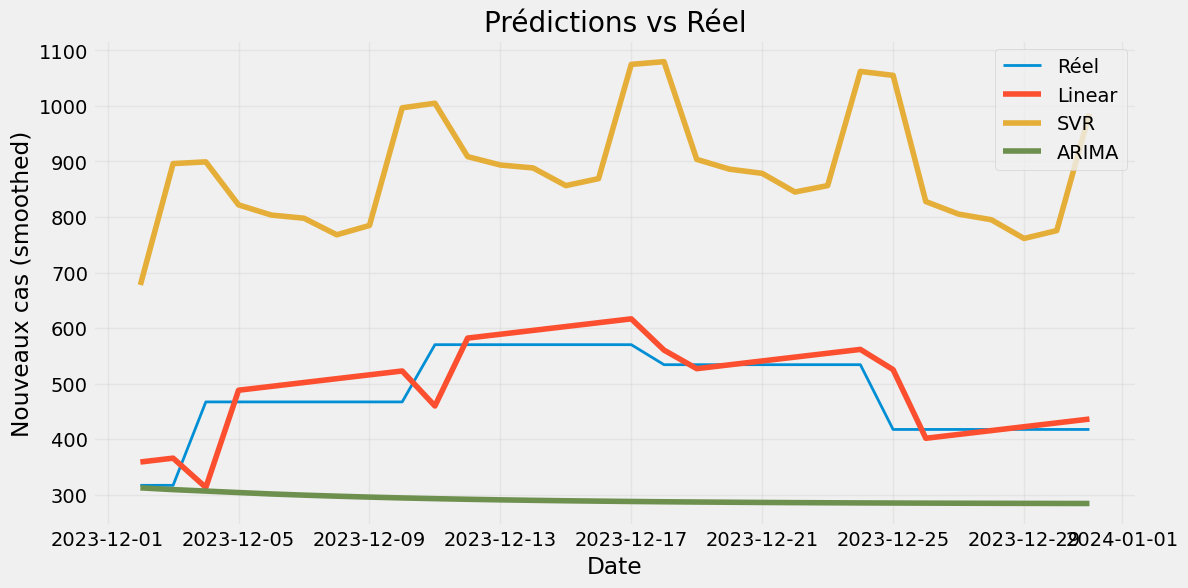


=== Résultats Netherlands ===
Linear -> MAE: 120.83, RMSE: 142.25
SVR -> MAE: 811.67, RMSE: 877.60
ARIMA -> MAE: 63.67, RMSE: 69.81


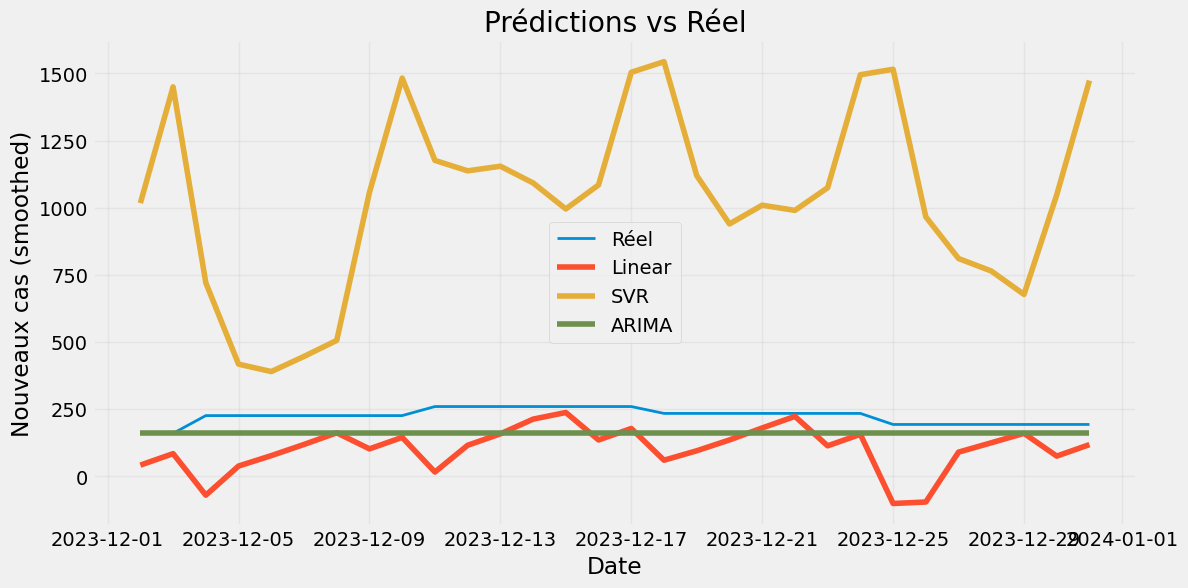


=== Résultats Luxembourg ===
Linear -> MAE: 5.95, RMSE: 11.29
SVR -> MAE: 24.12, RMSE: 27.95
ARIMA -> MAE: 28.93, RMSE: 31.79


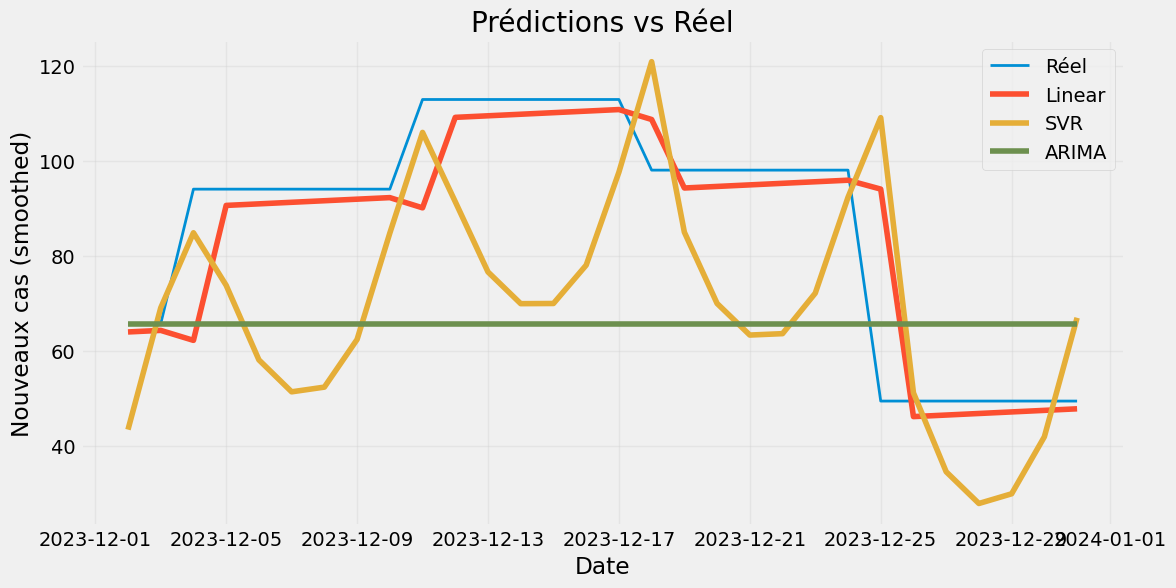


=== Résultats Switzerland ===
Linear -> MAE: 27.90, RMSE: 33.66
SVR -> MAE: 166.65, RMSE: 229.82
ARIMA -> MAE: 73.19, RMSE: 110.18


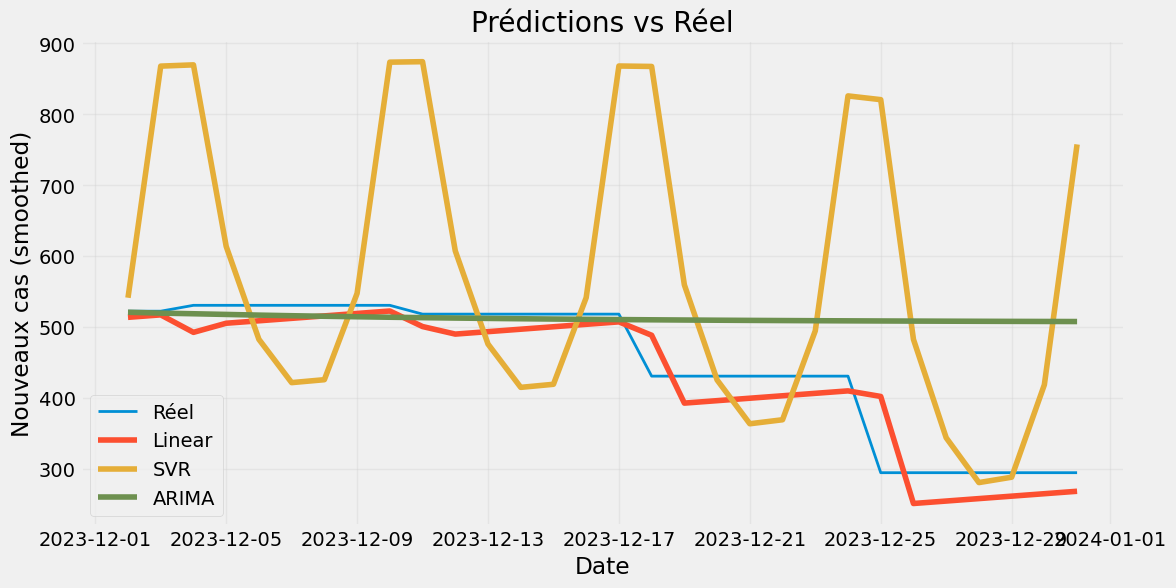


=== Résultats Austria ===
Linear -> MAE: 11.69, RMSE: 12.00
SVR -> MAE: 528.00, RMSE: 548.27
ARIMA -> MAE: 4.29, RMSE: 5.51


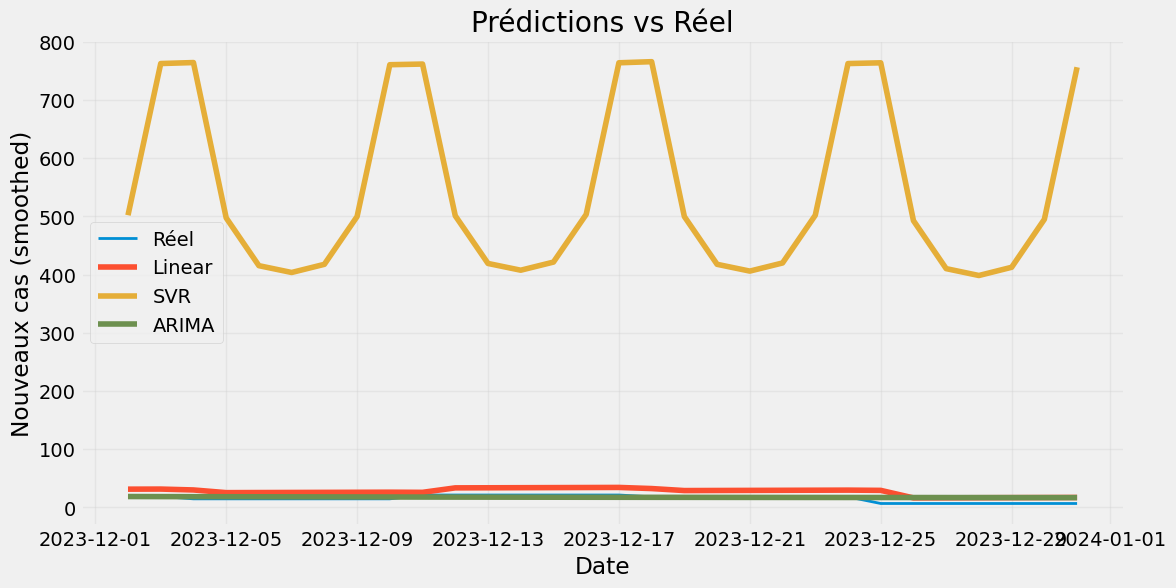


=== Résultats Poland ===
Linear -> MAE: 151.53, RMSE: 265.08
SVR -> MAE: 179.25, RMSE: 321.55
ARIMA -> MAE: 488.34, RMSE: 652.50


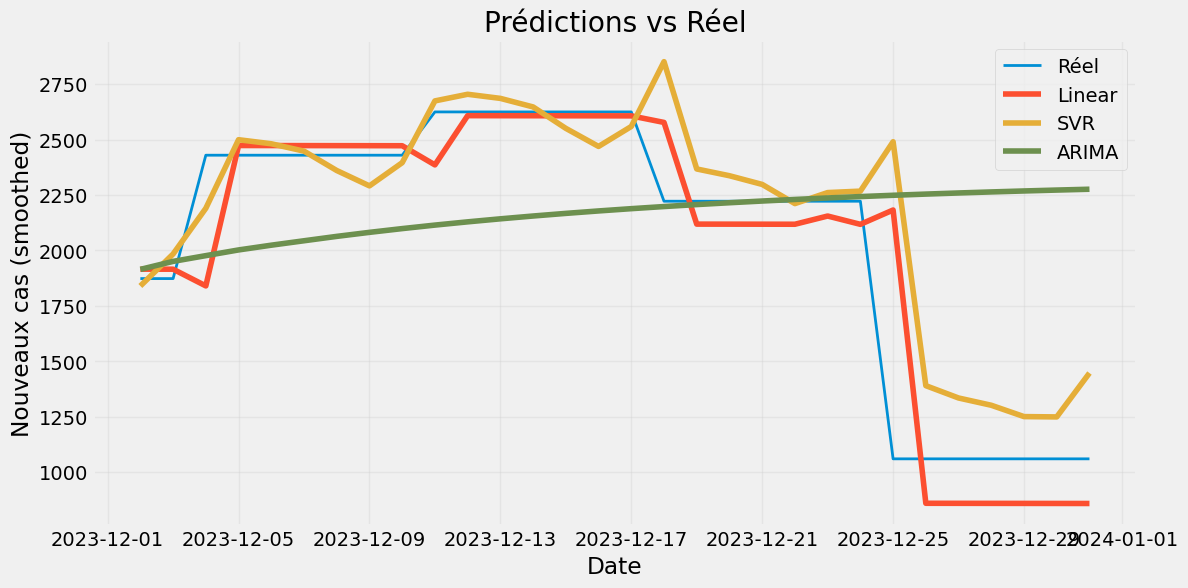

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# =========================================================
# MAIN
# =========================================================
if __name__ == "__main__":
    # # Charger données OWID (Our World In Data)
    # df_europe = load_and_filter("/Users/fanny/Desktop/Projet_ML/data/compact.csv")
    # df_europe = preprocess(df_europe)

    # print(df_europe.columns)

    sub = build_timeseries(df_europe, target="new_cases")

    # Définir features
    features = ["day_of_week", "lag1", "lag7"]
    for col in ["hosp_patients", "icu_patients", "total_vaccinations", "new_tests"]:
        if col in sub.columns:
            features.append(col)

    # # Train/Test
    # X_train, X_test, y_train, y_test = train_test_split_time(sub, features, test_size=30)

    # # ML models
    # preds = train_models(X_train, X_test, y_train, y_test)

    # # ARIMA
    # y_test_arima, arima_pred = train_arima(sub, test_size=30)
    # preds["ARIMA"] = arima_pred

    # # Eval
    # print(f"\n=== Résultats {country} ===")
    # evaluate(y_test, {k:v for k,v in preds.items() if k!="ARIMA"})
    # evaluate(y_test_arima, {"ARIMA": arima_pred})

    # # Plot
    # plot_results(sub["date"][-30:], y_test, preds)

preds_all = {}

for country in european_countries:
    sub_country = sub[sub["country"] == country].copy()
    
    # Train/Test
    X_train, X_test, y_train, y_test = train_test_split_time(sub_country, features, test_size=30)
    
    # ML models
    preds = train_models(X_train, X_test, y_train, y_test)
    
    # ARIMA
    y_test_arima, arima_pred = train_arima(sub_country, test_size=30)
    preds["ARIMA"] = arima_pred
    
    # Eval
    print(f"\n=== Résultats {country} ===")
    evaluate(y_test, {k:v for k,v in preds.items() if k!="ARIMA"})
    evaluate(y_test_arima, {"ARIMA": arima_pred})
    
    # Plot
    plot_results(sub_country["date"][-30:], y_test, preds)
    
    preds_all[country] = preds